# An Introduction to Rydberg atoms with ARC

Authors: Nikola Šibalić, Jonathan D. Pritchard, Charles S. Adams, Kevin J. Weatherill

Updated 30/05/2018

In this notebook:

1. [Configure Notebook](#Configure-Notebook)
2. [Rydberg atom energy levels](#Rydberg-Atom-Energy-Levels)
3. [Rydberg atom wavefunctions](#Rydberg-atom-wavefunctions)
4. [Matrix elements for atom interaction with electromagnetic radiation](#Matrix-Elements)
5. [Rydberg lifetimes and black-body radiation induced transitions](#Rydberg-Atom-Lifetimes)
6. [Creating highly excited states](#Creating-highly-excited-states)
7. [Rydberg atom energy level modifications in DC electric fields (Stark shifts)](#Rydberg-Atom-Stark-Shifts)
8. [Interaction between the two atoms excited to Rydberg states](#Rydberg-atom-interactions)
    * [Calculation of C6 (perturbative)](#Dispersion-Coefficients)
    * [Short range interactions and fitting C3, C6, Rvdw](#Short-range-interactions)
    * [Resonant interactions - calculation of C3 for a given channel](#Resonant-interactions)
    
9. [Tuning the interactions with external fields (Förster resonance)](#Tuning-the-interaction-strength-with-electric-fields)
10. [Atomic vapour properties](#General-atomic-properties)
11. [Advanced Rydberg examples](#Advanced-Rydberg-examples)
    * [Scalling of Rydberg blockade with principal quantum number](#Scalling-of-Rydberg-blockade-with-principal-quantum-number)
    * [Calculation of Le Roy radius](#Calculation-of-Le-Roy-radius)
    * [Off-resonant excitation](#Off-resonant-excitation)
    * [Matrix elements for (admixed) states in electric field](#Calculation-of-dipole-matrix-elements-between-states-in-static-electric-field)
12. [Advanced use of ARC package: interfacing and expansions](#Advanced-use-of-ARC-package:-interfacing-and-expansions)
    * [Saving and retrieving calculations](#Saving-and-retrieving-calculations)
    * [Export of data in .csv](Export-of-data-in-.csv)
    * [Using calculated matrices and basis states in your own projects](#Using-calculated-matrices-and-basis-states-in-your-own-projects)

### Configure Notebook
This notebook uses ARC package (Alkali Rydberg Calculator) that can be downloaded from [GitHub](https://github.com/nikolasibalic/ARC-Alkali-Rydberg-Calculator). Once you download the package to your computer set *rootDir* for the package below, and run the first cell, before continuing with other examples.

In [1]:
# Configure the matplotlib graphics library and configure it to show 

# show figures inline in the notebook
%matplotlib inline               
import matplotlib.pyplot as plt  # Import library for direct plotting functions
import numpy as np               # Import Numerical Python
from IPython.core.display import display, HTML #Import HTML for formatting output

# NOTE: Uncomment following lines ONLY if you are not using installation via pip
# import sys, os
# rootDir = '/path/to/arc/directory' # e.g. '/Users/Username/Desktop/ARC-Alkali-Rydberg-Calculator'
# sys.path.insert(0,rootDir)

from arc import *                 #Import ARC (Alkali Rydberg Calculator)

# Rydberg Atom Energy Levels

Rydberg states are highly excited states of the outer valence electron where the properties can be scaled in terms of the principal quantum number, $n$. Originally observed in the spectral lines of hydrogen, the binding energy of the Rydberg series are given by

\begin{equation}
E_{n\ell j} = - \frac{\mathrm{Ry}}{(n-\delta_{n\ell j})^2},
\end{equation}

where $n,\ell,j$ are the quantum numbers, $\mathrm{Ry}$ is the Rydberg constant and $\delta_{n\ell j}$ is the quantum defect. This defect describes the increase in binding energy for an alkali atom with respect to Hydrogen due to penetration and polarisation of the closed inner electron shells, which is most significant for the $\ell=0$ states with highly elliptical orbits, and can be neglected for states with $\ell>3$. The quantum defects are parameterised via

\begin{equation}
\delta_{n\ell j} = \delta_0 + \frac{\delta_2}{(n-\delta_0)^2}+\frac{\delta_4}{(n-\delta_0)^4}+ \ldots,
\end{equation}

with coefficients $\delta_{0,2,...}$ taken from measured energy levels.

The mass-corrected Rydberg constant is given by $\mathrm{Ry}=\mathrm{Ry}_\infty\times M/(M+m_e)$ where $m_e$ is the electron mass and $M$ is the atomic mass of the nucleus, with 

\begin{equation}
\mathrm{Ry}_\infty=\frac{e^4m_e}{16\pi^2\epsilon_0^2\hbar^2}.
\end{equation}

To demonstrate the effect of quantum defects, the graph below shows the energy levels of Cesium highlighting the effect of the quantum defect between the different $\ell$ manifolds.

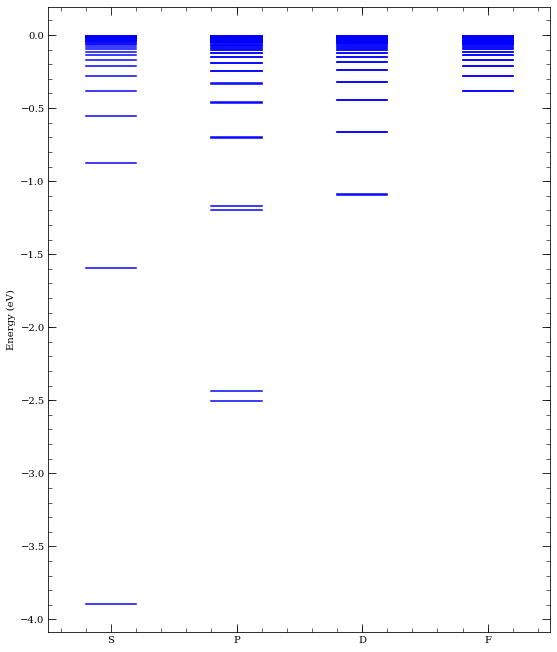

In [2]:
#Load parameters for Caesium
atom=Caesium()

nmin=6  #Minimum n
nmax=60 #Maximum n
lmin=0  #Minimum l
lmax=3  #Maxmium l

#Plot Energy Levels of Cesium
levels = LevelPlot(atom)
levels.makeLevels(nmin,nmax,lmin,lmax)
levels.drawLevels()
levels.showPlot()
# plot is interactive when called outside the IPython notebook (e.g. from Python program)

Text(0.5,1,'Cs Quantum Defects')

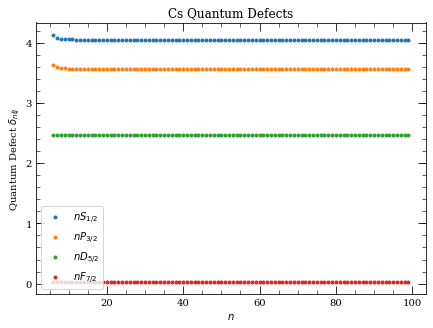

In [3]:
n=np.arange(6,100,1)
    
#Plot Quantum Defects of Cs
fig, axes = plt.subplots(1, 1, figsize=(7,5))

axes.plot(n,atom.getQuantumDefect(n,0,0.5),'.',label="$nS_{1/2}$")
axes.plot(n,atom.getQuantumDefect(n,1,1.5),'.',label="$nP_{3/2}$")
axes.plot(n,atom.getQuantumDefect(n,2,2.5),'.',label="$nD_{5/2}$")
axes.plot(n,atom.getQuantumDefect(n,3,3.5),'.',label="$nF_{7/2}$")
axes.legend(loc=0)
axes.set_xlabel('$n$')
axes.set_ylabel('Quantum Defect $\delta_{n\ell j}$')
axes.set_title('Cs Quantum Defects')


## Rydberg atom wavefunctions

Rydberg atom wavefunctions can be obtained from Schrödinger's equation,

\begin{equation}
\left[-\frac{1}{2\mu}\left(\frac{\mathrm{d}^2}{\mathrm{d} r^2} +\frac{2}{r}\frac{\mathrm{d}}{\mathrm{d} r}\right) + \frac{\ell(\ell+1)}{2\mu r^2} + V(r)\right]R(r)= E_{n\ell j}R(r),
\end{equation}

with reduced mass $\mu=Mm_e/(M+m_e)$ and $V(r)$ a model potential given by

\begin{equation}
V(r) = -\frac{Z_{n\ell}(r)}{r}-\frac{\alpha_c}{2r^4}(1-e^{-(r/r_c)^6})+V_{\rm so},
\end{equation}  

which at long range gives a $-1/r$ Colomb potential and at short range accounts for the finite size of the core, with radial charge given by

\begin{equation}
Z_{n\ell}(r) = 1+(Z-1)e^{-a_1r}-r(a_3+a_4r)e^{-a_2r}.
\end{equation}

Wavefunctions are calculated by numerical intergration of the model potential using parameters $a_{1..4},r_c$ and $\alpha_c$ taken from [Marinescu et.al](https://doi.org/10.1103/PhysRevA.49.982). Potential includes spin-orbit interaction $V_{\rm so}(r) = \alpha ~\mathbf{L}\cdot\mathbf{S}/(2r^3)$, where $\alpha$ is fine structure constant.

Rydberg atoms are large, with an average size $\langle r \rangle\propto n^2ea_0$, which leads to extremely large dipole matrix elements making them ideal for exploitng strong long range interactions. To illustrate this point, the probabiltiy distribution $\vert rR(r)\vert^2$ for $nS_{1/2}$ atomic wavefunctions are plotted below for increasing $n$ which highlights the dramatic scaling with atoms approaching $1~\mu$m in size for $n=100$ compared to $1~\unicode{x212B}$ for the groundstate!

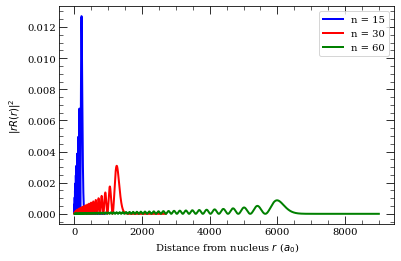

In [4]:
atom=Caesium()
pqn = [15,30,60] # principal quantum numbers of the states
colors = ["b","r","g"]
l = 0          # S state
j = 0.5        # J = 1/2

plotLegend = []
for i in range(len(pqn)):
    n = pqn[i]
    step = 0.001    
    a1,b1 = atom.radialWavefunction(l,0.5,j,\
                                       atom.getEnergy(n, l, j)/27.211,\
                                       atom.alphaC**(1/3.0),\
                                       2.0*n*(n+15.0), step)
    legendInfo, = plt.plot(a1,(b1)*(b1),\
                           "-",lw=2,color = colors[i], label = ("n = %d" % n) )
    plotLegend.append(legendInfo)
    
plt.legend(handles=plotLegend)
plt.xlabel(r"Distance from nucleus $r$ ($a_0$)")
plt.ylabel(r"$\vert rR(r)\vert^2$")
plt.show()

## Matrix Elements

#### Dipole Matrix Elements

Relevant properties of the Rydberg states can be derived through evaluation of dipole matrix elements. Recalling the separability of the atomic wavefunctions into radial and spherical components $\psi(r,\theta,\phi)=Y_{\ell,m_\ell}(\theta,\phi)R_{n\ell}(r)$ in the uncoupled basis, the dipole matrix elements can be expressed as

\begin{equation}
\langle n,\ell,m_\ell\vert r_q \vert n',\ell',m_\ell' \rangle = (-1)^{\ell-m_\ell}\begin{pmatrix}\ell&1&\ell'\\-m_\ell&q&m_\ell'\end{pmatrix}\langle\ell \vert\vert r\vert\vert\ell'\rangle,
\end{equation}

where $q=-1,0,1$ corresponds to $\sigma^+,\pi$ and $\sigma^-$ transitions respectively with the reduced matrix element

\begin{equation}
\langle\ell\vert\vert r\vert\vert\ell'\rangle = (-1)^\ell\sqrt{(2\ell+1)(2\ell'+1)}\begin{pmatrix}\ell&1&\ell\\0&0&0\end{pmatrix}\mathcal{R}_{n\ell\rightarrow n'\ell'},
\end{equation}

where round braces denote Wigner-$3j$ symbols and the radial matrix element is evaluated from 

\begin{equation}
\mathcal{R}_{n\ell\rightarrow n'\ell'} = \int_{r_{\rm i}}^{r_{\rm o}} R_{n,\ell}(r)rR_{n',\ell'}(r)r^2\mathrm{d} r.
\end{equation}

For highly excited states the hyperfine-structure splitting becomes negligible, however the fine-structure splitting $\hat{\mathcal{H}}=\beta \bf\hat{L}\cdot\hat{S}$ means the relevant basis is then fine structure basis ($j,m_j$) with matrix elements

\begin{equation}
\langle n,\ell,j,m_j\vert r_q \vert n',\ell',j',m_j' \rangle = (-1)^{j-m_j}\begin{pmatrix}j&1&j'\\-m_j&q&m_j'\end{pmatrix}\langle j \vert\vert r\vert\vert j'\rangle,
\end{equation}

and the reduced matrix element equal to

\begin{equation}
\langle j \vert\vert r\vert\vert j'\rangle = (-1)^{\ell+s+j'+1}\delta_{s,s'}\sqrt{(2j+1)(2j'+1)}
\begin{Bmatrix}j&1&j'\\\ell'&s&\ell\end{Bmatrix}\langle \ell\vert\vert r\vert\vert\ell'\rangle, 
\end{equation}

where the curly braces denote a Wigner-$6j$ symbol.

The cell below demonstrates how to extract the relevent matrix elements for different transitions and highlights the extremely large matrix elements of the Rydberg states for transitions to neighbouring states, which scale $\propto n^2$ due to the large electron radius shown above. Thus whilst the alkali $D$ line transitions have elements of order $~e a_0$, the Rydberg states can have $>1000~e a_0$ making them ideally suited for exploiting strong, long range interactions as will be explored below.

#### Quadrupole Matrix Elements 

For accurate interaction potentials at short range, it is necessary to also consider quadrupole matrix elements for the Rydberg atoms. getQuadrupoleMatrixElement

\begin{equation}
\mathcal{R}^Q_{n\ell\rightarrow n'\ell'} = \int_{r_{\rm i}}^{r_{\rm o}} R_{n',\ell}(r)r^2R_{n,\ell'}(r)r^2\mathrm{d} r.
\end{equation}


In [5]:
#Cs D2 Transition 6S_{1/2}-->6P_{3/2}
n1=6
l1=0
j1=0.5
mj1=0.5
n2=6
l2=1
j2=1.5
mj2=1.5
q=+1
print("Cs D2 Transition 6S_{1/2}-->6P_{3/2}")
print("====================================")
#Radial Matrix element R_{nlj\rightarrown'l'j'}
print("R_{nlj-n'l'j'} = %.3f ea_0" % atom.getRadialMatrixElement(n1,l1,j1,n2,l2,j2))
#Reduced Matrix Element <l||er||l'>
print("<l||er||l'> = = %.3f ea_0" % atom.getReducedMatrixElementL(n1,l1,j1,n2,l2,j2))
#Reduced Matrix Element <j||er||j'>
print("<j||er||j'> = %.3f ea_0" % atom.getReducedMatrixElementJ(n1,l1,j1,n2,l2,j2))
#Angular Coupling
print("<nljmj|er|n'l'j'mj'> = %.3f ea_0\n" %\
        atom.getDipoleMatrixElement(n1,l1,j1,mj1,n2,l2,j2,mj2,q))

#Cs Rydberg Transition 60S_{1/2}-->60P_{3/2}
n1=60
l1=0
j1=0.5
mj1=0.5
n2=60
l2=1
j2=1.5
mj2=1.5
q=+1

print("Cs Rydberg Transition 60S_{1/2}-->60P_{3/2}")
print("===========================================")
#Radial Matrix element R_{nlj\rightarrown'l'j'}
print("R_{nlj-n'l'j'} = %.3f ea_0" % atom.getRadialMatrixElement(n1,l1,j1,n2,l2,j2))
#Reduced Matrix Element <l||er||l'>
print("<l||er||l'> = = %.3f ea_0" % atom.getReducedMatrixElementL(n1,l1,j1,n2,l2,j2))
#Reduced Matrix Element <j||er||j'>
print("<j||er||j'> = %.3f ea_0" % atom.getReducedMatrixElementJ(n1,l1,j1,n2,l2,j2))
#Angular Coupling
print("<nljmj|er|n'l'j'mj'> = %.3f ea_0\n" % \
        atom.getDipoleMatrixElement(n1,l1,j1,mj1,n2,l2,j2,mj2,q))

Cs D2 Transition 6S_{1/2}-->6P_{3/2}
R_{nlj-n'l'j'} = -5.477 ea_0
<l||er||l'> = = 5.477 ea_0
<j||er||j'> = 6.324 ea_0
<nljmj|er|n'l'j'mj'> = 3.162 ea_0

Cs Rydberg Transition 60S_{1/2}-->60P_{3/2}
R_{nlj-n'l'j'} = 3563.326 ea_0
<l||er||l'> = = -3563.326 ea_0
<j||er||j'> = -4114.575 ea_0
<nljmj|er|n'l'j'mj'> = -2057.287 ea_0



For low-lying states, Numerov integration is usually not accurate enough in estimating dipole matrix element. Package also has a .csv table for each element, that can be manually expanded if needed, with various literature values for dipole matrix elements. These values are either obtained experimentally, or by more advanced theoretical calculations. If value is existing in the literature, package will by default use the literature value with the smallest error estimate.

In [6]:
atom = Caesium()
hasLiteratureValue,dme, info = atom.getLiteratureDME(6,1,1.5,7,0,0.5)
if hasLiteratureValue:
    print("%.2f ea_0" % dme)
    # additional information about the source
    s = "experiment"
    if info[0]==1:
        s = "theory"
    print(" source = %s\n errorEstimate = %.2f\n comment = %s\n reference = %s\n doi = %s" % \
        (s,info[1],info[2],info[3],info[4]))

5.61 ea_0
 source = theory
 errorEstimate = 0.01
 comment = scaled, table VI
 reference = Physical Review A, 60 4476 (1999)
 doi = 10.1103/PhysRevA.60.4476


## Rydberg Atom Lifetimes

Rydberg atoms have suprisingly long radiative lifetimes. For example lifetimes of $nS$ states are of the order of $10~\mu$s, for $n\sim30$. Lifetimes $\tau$ of $n$ states, with small orbital angular momenutum $\ell$ like $S$ or $P$ states, scales as $\tau\propto n_*^3$ where $n_*=n-\delta$ is the effective principal quantum number. Of all possible $\ell$ states, circular states $\ell=n-1$ have longest lifetimes, that scales as $\tau \propto n_*^5$.

In [7]:
atom = Rubidium()
print("%.2e s" % (atom.getStateLifetime(30,0,0.5)) )

2.43e-05 s




The radiative lifetime is calculated from the Einstein-A coefficients as $1/\tau_0=\sum_{n'\ell'}A_{n\ell\rightarrow n'\ell'}$, with the summation over all dipole coupled states with energy $E_{n'\ell'}<E_{n\ell}$ and the A-coefficient calculated as

\begin{equation}
A_{n\ell\rightarrow n'\ell'}=\frac{4\omega_{nn'}^3}{3c^3}\frac{\ell_\mathrm{max}}{2\ell+1}\mathcal{R}^2_{n\ell\rightarrow n'\ell'}.
\end{equation}

Here the prefactor of $\omega_{nn'}^3$ means that although the dipole matrix element for transitions to nearby $n$ states is much larger than that for transitions to the ground state (e.g. Cs $\langle 60 S_{1/2}|er| 60 P_{3/2}\rangle = 4114 ~ea_0$ compared to $\langle 6 S_{1/2}|er| 60 P_{3/2}\rangle = 0.0038 ~ea_0$), the A-coefficients for these two transitions are $1.9\mathrm{s}^{-1}$ and $224\mathrm{s}^{-1}$ respectively, resulting in the lowest energy transitions being the dominant decay pathways for radiative decay from the Rydberg states.

At finite temperature, the black-body excitation spectrum causes a reduction in the lifetime due to driving transitions in the GHz and THz region to neighbouring Rydberg states both above and below the energy of the original Rydberg state. The black body loss is given by

\begin{equation}
\frac{1}{\tau_\mathrm{BBR}}=\displaystyle\sum_{n'\ell'} \frac{A_{n\ell\rightarrow n'\ell'}}{\exp(\omega_{nn'}/k_\mathrm{B}T)-1},
\end{equation}

with the effective lifetime $1/\tau_\mathrm{eff}=1/\tau_0+1/\tau_\mathrm{BBR}$.

The figure below demonstrates the finite temperature effects by showing the strength of the diffent decay pathways for the $30S_{1/2}$ state in Rb at 300K showing the contribution from radiative decay (red columns) and black-body induced transitions (green). The effective lifetime is reduced by around a factor of 2 at room temperature compared to the natural lifetime.

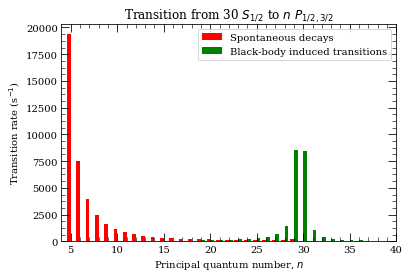

In [8]:
atom = Rubidium()
    
pqn = []
y = []
ybb = []
    
for n in xrange(5,40):
    pqn.append(n)
    noBBR = atom.getTransitionRate(30, 0, 0.5, n, 1, 0.5, temperature=0.1)\
            +atom.getTransitionRate(30, 0, 0.5, n, 1, 1.5, temperature=0.1)
    withBBR =  atom.getTransitionRate(30, 0, 0.5, n, 1, 0.5, temperature=300.0)\
            +atom.getTransitionRate(30, 0, 0.5, n, 1, 1.5, temperature=300.0)
    y.append(noBBR)
    ybb.append(withBBR-noBBR)
    
pqn=np.array(pqn) 
y = np.array(y)
ybb = np.array(ybb)

width = 0.4
plt.bar(pqn-width/2.,y,width=width,color="r")
plt.bar(pqn+width/2.,ybb,width=width,color="g")
plt.xlabel("Principal quantum number, $n$")
plt.ylabel(r"Transition rate (s${}^{-1}$)")
plt.title("Transition from 30 $S_{1/2}$ to $n$ $P_{1/2,3/2}$")
plt.legend(("Spontaneous decays","Black-body induced transitions"),fontsize=10)
plt.xlim(4,40)
plt.show()

display(HTML("Lifetime (0 K) &tau;<sub>0</sub> = %.2f &mu;s" % \
             (atom.getStateLifetime(30,0,0.5) *1.e6)))
display(HTML("Lifetime (300 K) &tau;<sub>eff</sub> = %.2f &mu;s" % \
             (atom.getStateLifetime(30,0,0.5,temperature=300.,includeLevelsUpTo=39) *1.e6)))

This plot can be compared with Fig. 1 in Ref. [I. I. Beterov et. al, PRA **79**, 052504(2009)](https://doi.org/10.1103/PhysRevA.79.052504). Similarly, we can reproduce black-body induced state depopulation rates (see Fig. 2 in the same reference):

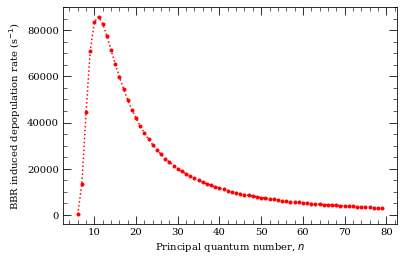

In [9]:
atom = Rubidium()
stateL = 1; stateJ = 1.5 # P_{1/2} states
BBRdepopulationRate = []
nList = np.arange(6,80)
for n in nList:
    noBBR = 1./atom.getStateLifetime(n,stateL,stateJ,temperature=0)
    withBBR = 1./atom.getStateLifetime(n,stateL,stateJ,temperature=300,includeLevelsUpTo=n+10)
    BBRdepopulationRate.append(withBBR-noBBR)
ax = plt.subplot(111)
ax.plot(nList,BBRdepopulationRate,"r.:")
ax.set_xlabel(r"Principal quantum number, $n$")
ax.set_ylabel(r"BBR induced depopulation rate (s$^{-1}$)")
plt.show()

Comparing lifetimes for different principal quantum numbers $n$ and orbital angular momentum states $l$, we see that lifetimes for $nP$ scale as $\propto n_*^3$, and lifetimes for circular states $n,l=n-1$ scale as $\propto n_*^5$

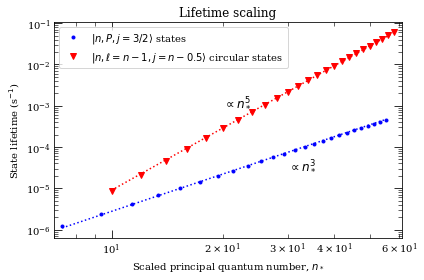

In [10]:
atom = Rubidium()
pqn = np.arange(10,60,2)

nstar1 = []; nP_lifetime = []
nstar2 = []; circular_state_lifetime = []

for n in pqn:
    nstar1.append(n - atom.getQuantumDefect(n,1,1.0+0.5))
    nP_lifetime.append(atom.getStateLifetime(n,1,1.0+0.5))

    nstar2.append(n - atom.getQuantumDefect(n,n-1,n-1.5))
    circular_state_lifetime.append(atom.getStateLifetime(n,n-1,n-0.5))

nstar1 = np.array(nstar1); nP_lifetime = np.array(nP_lifetime)
nstar2 = np.array(nstar2); circular_state_lifetime = np.array(circular_state_lifetime)
    
f = plt.figure()
ax = f.add_subplot(1,1,1)
ax.loglog(nstar1,nP_lifetime,"b.")
ax.loglog(nstar2,circular_state_lifetime,"rv")


# fitting n^3 dependance for nP state lifetime
def func3(x, a):
    return a+3*x
popt, pcov = curve_fit(func3, np.log(nstar1), np.log(nP_lifetime))
ax.loglog(nstar1,np.exp(func3(np.log(nstar1),*popt)),"b:")

# fitting n^5 dependance for n,l=n-1 streatched state lifetime
def func5(x, a):
    return a+5*x
popt, pcov = curve_fit(func5, np.log(nstar2), np.log(circular_state_lifetime))
ax.loglog(nstar2,np.exp(func5(np.log(nstar2),*popt)),"r:")

ax.set_title("Lifetime scaling")
ax.legend([r"$|n,P,j=3/2\rangle$ states",r"$|n,\ell=n-1,j=n-0.5\rangle$ circular states"],loc=2,fontsize=10)
ax.text(20,1e-3,r"$\propto n_*^5$",fontsize=12)
ax.text(30,3e-5,r"$\propto n_*^3$",fontsize=12)
ax.set_xlim(7,61)
ax.set_xlabel("Scaled principal quantum number, $n_*$")
ax.set_ylabel("State lifetime (s$^{-1}$)")
plt.tight_layout()



## Creating highly excited states

Rydberg atoms are highly excited atoms. If the excitation is done in single step necessary energy would typically correspond to UV radition. For example, in Caesium $6 S_{1/2} \rightarrow 60 P_{3/2}$ requred transition wavelength and frequencies are

In [11]:
atom = Caesium()
print("Cs Excitation 6S_{1/2} -> 60P_{3/2}")
n1=6;l1=0;j1=0.5; #Initial State
n2=60;l2=1;j2=1.5; #Final State
print("lambda = %.3f nm" % (atom.getTransitionWavelength(n1,l1,j1,n2,l2,j2)*1e9))
print("omega/2pi = %.3f THz" % (atom.getTransitionFrequency(n1,l1,j1,n2,l2,j2)*1e-12))

Cs Excitation 6S_{1/2} -> 60P_{3/2}
lambda = 318.755 nm
omega/2pi = 940.509 THz


#### Rabi Frequency
The transition strength is characterised by the Rabi frequency $\Omega=d\cdot\mathcal{E}/\hbar$, where $d$ is the dipole matrix element calcualte above and $\mathcal{E}$ is the electric field of the laser driving the excitation. Recalling that for a Gaussian beam with $1/e^2$ radius of $w_0$ and power $P$, the intensity is given by
\begin{equation}
I=\frac{2P}{\pi w_0^2},
\end{equation}
which is related to the electric field by $I=(1/2)c\epsilon_0\vert \mathcal{E}\vert ^2$, resulting in the Rabi frequency of

\begin{equation}
\Omega = \sqrt{\frac{4P}{\epsilon_0c\pi w_0^2}}\frac{\langle n,\ell,j,m_j\vert r_q \vert n',\ell',j',m_j' \rangle}{\hbar}.
\end{equation}

Due to the weak overlap between the ground and highly excited Rydberg states (which scales as $\sim n^{*-3/2}$), the resulting matrix elements are relatively small meaning large intensities are required. As an example, consider a 1 W UV laser driving the transition above with a $1/e^2$ waist of 50 $\mu$m. The resulting Rabi frequency is only $\Omega/2\pi=10$ MHz!

In [12]:
#Laser Parameters
waist = 50.e-6 # 50 mu m
P = 1000.e-3 # 500 mW

mj1=0.5;
mj2=1.5;
q=+1; #Light Polarisation (sigma+)

rabiFreq = atom.getRabiFrequency(n1,l1,j1,mj1,n2,l2,j2,q,P,waist)
print("rabi Frequency = 2 pi x %.2f MHz" %(rabiFreq/(2*pi)*1e-6))

rabi Frequency = 2 pi x 10.58 MHz


An alternative way to reach these highly excited states is to use a mutli-step excitation scheme with a number of lasers of different wavelength. This enables use of transitions with favourable or convenient wavelengths (for example standard diode/fiber laser sources) with high power or strong transitions. The most commonly used is a two-step excitation via the D-line transition in the alkali's, with the added benefit of enabling electromagnetically induced transparency (EIT) to be engineered for mapping strong Rydberg interactions onto optical photons. In Rubidium, typically the $5 S_{1/2} \rightarrow 5 P_{3/2} \rightarrow 60 S_{1/2}$ transition is favoured, whose properties are

In [13]:
atom = Rubidium()
print("5 S_{1/2} -> 5 P_{3/2}")
print("%.3f nm " % (atom.getTransitionWavelength(5,0,0.5,5,1,1.5)*1e9))
print("%.3f THz " % (atom.getTransitionFrequency(5,0,0.5,5,1,1.5)*1e-12))
print("5 P_{3/2} -> 60 S_{1/2}")
print("%.3f nm " % (atom.getTransitionWavelength(5,1,1.5,60,0,0.5)*1e9))
print("%.3f THz " % (atom.getTransitionFrequency(5,1,1.5,60,0,0.5)*1e-12))

5 S_{1/2} -> 5 P_{3/2}
780.241 nm 
384.230 THz 
5 P_{3/2} -> 60 S_{1/2}
479.839 nm 
624.777 THz 


One can use even more involved schemes, for example in Ceasium three lasers can be used $6 S_{1/2} \rightarrow 6 P_{3/2} \rightarrow 7 S_{1/2} \rightarrow 60 P_{3/2}$. Note that now all the lasers are conveniantly in the near infrared (NIR) range!

In [14]:
atom = Caesium()
print("6 S_{1/2} -> 6 P_{3/2}")
print("%.3f nm " % (atom.getTransitionWavelength(6,0,0.5,6,1,1.5)*1e9))
print("%.3f THz " % (atom.getTransitionFrequency(6,0,0.5,6,1,1.5)*1e-12))
print("6 P_{3/2} -> 7 S_{1/2}")
print("%.3f nm " % (atom.getTransitionWavelength(6,1,1.5,7,0,0.5)*1e9))
print("%.3f THz " % (atom.getTransitionFrequency(6,1,1.5,7,0,0.5)*1e-12))
print("7 S_{1/2} -> 60 P_{3/2}")
print("%.3f nm " % (atom.getTransitionWavelength(7,0,0.5,60,1,1.5)*1e9))
print("%.3f THz " % (atom.getTransitionFrequency(7,0,0.5,60,1,1.5)*1e-12))

6 S_{1/2} -> 6 P_{3/2}
852.347 nm 
351.726 THz 
6 P_{3/2} -> 7 S_{1/2}
1469.892 nm 
203.955 THz 
7 S_{1/2} -> 60 P_{3/2}
779.029 nm 
384.828 THz 


Or, even four lasers can be achieved in order to couple to Rydberg states. For example [reference] $6 S_{1/2} \rightarrow 6P_{3/2} \rightarrow 7S_{1/2} \rightarrow 8 P_{1/2} \rightarrow 52 D_{3/2}$

In [15]:
print("6 S_{1/2} -> 6 P_{3/2}")
print("%.3f nm " % (atom.getTransitionWavelength(6,0,0.5,6,1,1.5)*1e9))
print("%.3f THz " % (atom.getTransitionFrequency(6,0,0.5,6,1,1.5)*1e-12))
print("6 P_{3/2} -> 7 S_{1/2}")
print("%.3f nm " % (atom.getTransitionWavelength(6,1,1.5,7,0,0.5)*1e9))
print("%.3f THz " % (atom.getTransitionFrequency(6,1,1.5,7,0,0.5)*1e-12))
print("7 S_{1/2} -> 8 P_{3/2}")
print("%.3f nm " % (atom.getTransitionWavelength(7,0,0.5,8,1,1.5)*1e9))
print("%.3f THz " % (atom.getTransitionFrequency(7,0,0.5,8,1,1.5)*1e-12))
print("8 P_{1/2} -> 52 D_{3/2}")
print("%.3f nm " % (atom.getTransitionWavelength(8,1,0.5,52,2,1.5)*1e9))
print("%.3f THz " % (atom.getTransitionFrequency(8,1,0.5,52,2,1.5)*1e-12))

6 S_{1/2} -> 6 P_{3/2}
852.347 nm 
351.726 THz 
6 P_{3/2} -> 7 S_{1/2}
1469.892 nm 
203.955 THz 
7 S_{1/2} -> 8 P_{3/2}
1378.174 nm 
217.529 THz 
8 P_{1/2} -> 52 D_{3/2}
1769.006 nm 
169.469 THz 


Now even with moderate laser powers we can reach highly-excited states. For example for 10 mW laser focused down to 50 $\mu$m driving $8~P_{1/2}~m_j=1/2 \rightarrow 52~D_{3/2}~m_j=1/2$ we achieve 

In [16]:
waist = 50e-6 # 50 mu m
P = 10.e-3 # 10 mW
rabiFreq = atom.getRabiFrequency(8,1,1.5,0.5,52,2,1.5,0.5,P,2*waist)
print("rabi Frequency = 2 pi x %.2f MHz" %(rabiFreq/(2*pi)*1e-6))

rabi Frequency = 2 pi x 1.58 MHz


### Quadrupole matrix elements

We can also obtain quadrupole matrix elements. For example, $5 S_{1/2}\rightarrow n D_{5/2}$ transitions, that have been also calculated in [D. Tong et.al, PRA **79**, 052509 (2009)](https://doi.org/10.1103/PhysRevA.79.052509) (see Table I there), we can obtain by calling


In [17]:
atom = Rubidium()
nList = [24,27,29,34,39,44,47,49,54,59]
for n in nList:
    print("%.2e e^2 a_0^4" % atom.getQuadrupoleMatrixElement(5,0,0.5,n,2,2.5)**2)

1.15e-01 e^2 a_0^4
7.94e-02 e^2 a_0^4
6.35e-02 e^2 a_0^4
3.87e-02 e^2 a_0^4
2.52e-02 e^2 a_0^4
1.74e-02 e^2 a_0^4
1.42e-02 e^2 a_0^4
1.25e-02 e^2 a_0^4
9.26e-03 e^2 a_0^4
7.06e-03 e^2 a_0^4


## Rydberg Atom Stark Shifts

The large dipole moment of the Rydberg states makes them highly polarisable. For an atom in a d.c. electromagnetic field $\mathcal{E}$ directed along the $z$-axis, the interaction leads to a coupling given by

\begin{equation}
\mathcal{H} = \mathcal{H}_0 + \mathcal{E}\hat{z}, 
\end{equation}

where $\mathcal{H}_0$ is the Hamiltonian for the unperturbed energy levels and $\hat{z}\equiv r_0$ in the spherical basis resulting in a selection rule $\Delta m_j=0$ and a shift dependent on $\vert m_j \vert$. For the low-$\ell$ states, the quantum defects cause the first-order Stark-shift to vanish, resulting in a second-order energy shift $\Delta E = -\frac{1}{2}\alpha_0\mathcal{E}^2$ where the polarizability for state $\vert n \ell j m_j\rangle$ is given by

\begin{equation}
\alpha_0 = 2 e^2\displaystyle\sum_{n'\ell'j'\neq n\ell j} \frac{\vert \langle n,\ell,j,m_j\vert r_0 \vert n',\ell',j',m_j' \rangle \vert^2}{E_{n'\ell' j'}-E_{n\ell j}}.
\end{equation}

Since the dipole matrix elements scale as $n^{2}$, and the energy difference scales as $n^{-3}$ the scalar polarizability $\alpha_0\propto n^7$. States with $\ell>3$ are degenerate, and therefore experience a linear Stark shift. 

The evaluation of polarisability using second-order perturbation theory is limited, and only valid at weak fields. Instead, Stark maps accurate to all orders can be obtained by direct diagonalisatoin of the Hamiltonian $\mathcal{H}$, taking care to include a large enough set of basis states to achieve divergence. As well as revealing the exact energies of the Stark-coupled states, this permits extraction of the mixed electric field eigenstates which are relevant when considering optical excitation of a given Rydberg state which is now mixed into neighbouring energy levels.

The code below provides an example Stark map for the $35S_{1/2},\vert m_j\vert=1/2$ state in Cesium. After identifying the target state, a range of basis states are defined before running the diagonalisation for the range of E-fields specified, returning the desired Stark map. To show the effect of state mixing, the levels are coloured proportional to the fraction of the target state present in each eigenstate. This knowledge can also be used to determine the effective polarisability by extracting the energy level of the eigenstate with a contribution of at least 90% of the original target state.

For high $n$, the range of basis states may need to be increased due to the reduction in energy spacings but this can easily be checked for convergence by running twice with a larger basis set.


Found  410  states.
Generating matrix...
100%

Finding eigenvectors...
100%

plotting...


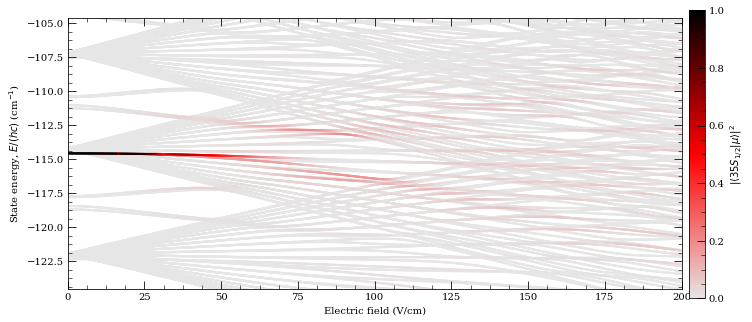

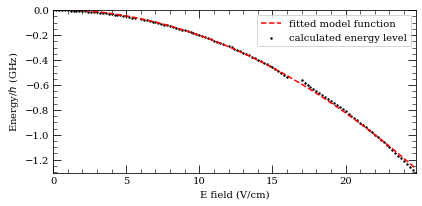

4.15576 MHz cm^2 / V^2 


In [18]:
#Stark Map Caclulator
#====================
#Initialise a Stark-shift Solver for Caesium
calc = StarkMap(Caesium())

#Target state
n0=35;l0=0;j0=0.5;mj0=0.5;  
#Define max/min n values in basis
nmax=40
nmin=30
#Maximum value of l to include (l~20 gives good convergence for states with l<5)
lmax=20

#Initialise Basis States for Solver : progressOutput=True gives verbose output
calc.defineBasis(n0, l0, j0, mj0, nmin, nmax, lmax, progressOutput=True)

Emin=0. #Min E field (V/m)
Emax=20000. #Max E field (V/m)
N=1001 #Number of Points

#Generate Stark Map
calc.diagonalise(np.linspace(Emin,Emax,N), progressOutput=True)
#Show Sark Map
calc.plotLevelDiagram(progressOutput=True,units=1,highlighState = True)
calc.showPlot(interactive = False)
#Return Polarizability of target state    
print("%.5f MHz cm^2 / V^2 " % calc.getPolarizability(showPlot=True, minStateContribution=0.9))
    

We can compare values for the polarizability with the measurements in the literature. For example, we can get theoretical predictions for results cited in Ref. [M. S. O'Sullivan and B. P. Stoicheff, PRA **31**, 2718 (1985)](https://doi.org/10.1103/PhysRevA.31.2718) (see Table I there) by calling the following

In [20]:
calc = StarkMap(Rubidium())


stateN = [15,20,25,30,35,40,45,50,55,60,63,65,67,70,75,80]
eFieldRange = np.array([[90,492],[28,188],[19,75],[4,28],[4,14],\
                        [1,5],[1.4,3.2],[0.7,2],[0.6,1],[0.15,0.7],\
                        [0.35,0.7],[0.2,0.7],[0.15,0.45],[0.15,0.3],\
                        [0.003,0.2],[0.1,0.16]])*1.e2 # V/m ranges
polarizabilityList = []
print("State\t\tPolarizability (MHz cm^2 / V^2)\t\tElectric field range (V/cm)")

for i in xrange(len(stateN)):
    n = stateN[i]
    calc.defineBasis(n, 0, 0.5, 0.5, n-5, n+5, 20) #,progressOutput=True)
    minEfield = eFieldRange[i][0]
    maxEfield = eFieldRange[i][1]
    calc.diagonalise(np.linspace(minEfield,maxEfield,100)) # ,progressOutput=True)
    p = calc.getPolarizability( minStateContribution=0.9)
    print("%s\t%.3e\t\t\t\t%.2f-%.2f" % \
        (printStateString(n,0, 0.5), p, minEfield/100.,maxEfield/100.))
    polarizabilityList.append(p)


State		Polarizability (MHz cm^2 / V^2)		Electric field range (V/cm)
15 S 1/2	7.995e-03				90.00-492.00
20 S 1/2	7.233e-02				28.00-188.00
25 S 1/2	3.755e-01				19.00-75.00
30 S 1/2	1.396e+00				4.00-28.00
35 S 1/2	4.208e+00				4.00-14.00
40 S 1/2	1.067e+01				1.00-5.00
45 S 1/2	2.457e+01				1.40-3.20
50 S 1/2	5.148e+01				0.70-2.00
55 S 1/2	9.957e+01				0.60-1.00
60 S 1/2	1.821e+02				0.15-0.70
63 S 1/2	2.611e+02				0.35-0.70
65 S 1/2	3.251e+02				0.20-0.70
67 S 1/2	3.955e+02				0.15-0.45
70 S 1/2	5.323e+02				0.15-0.30
75 S 1/2	8.532e+02				0.00-0.20
80 S 1/2	1.353e+03				0.10-0.16


This data can be compared also with analytical fit function that they recommend as a polarizability estimate.

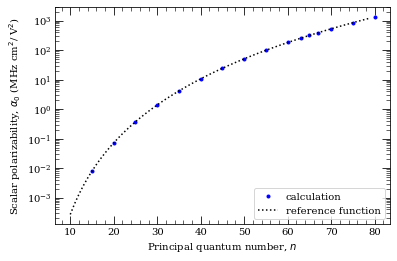

In [21]:
ax = plt.subplot(1,1,1)
ax.semilogy(stateN,polarizabilityList,"b.")
ax.set_xlabel(r"Principal quantum number, $n$")
ax.set_ylabel(r"Scalar polarizability, $\alpha_0$ (MHz cm$^2$/ V$^2$)")

def functionFromReference_Rb_S_states(atom,n):
    # recommended fit function from M. S. O'Sullivan and B. P. Stoicheff, PRA 31, 2718 (1985) 
    scaledPQN = n - atom.getQuantumDefect(n,0,0.5)
    return 2.202*1.e-9*scaledPQN**6 + 5.53*1.e-11*scaledPQN**7

nValues = np.arange(10,80)
referenceFunction = [functionFromReference_Rb_S_states(calc.atom,n) for n in nValues]
ax.semilogy(nValues,referenceFunction,"k:")
plt.legend(("calculation","reference function"),loc=4,fontsize=10)
plt.show()

We can also compare our calculations with recent calculations and measurements from [J. Grimmel et.al, NJP **17**, 053005 (2015)](http://iopscience.iop.org/article/10.1088/1367-2630/17/5/053005/meta) for Rubidium $35 S_{1/2}$ and $70 S_{1/2}$ states

Found  1636  states.
Generating matrix...
100%

Finding driving field coupling...
100%

Finding eigenvectors...
100%

Found  1584  states.
Generating matrix...
100%

Finding driving field coupling...
100%

Finding eigenvectors...
100%

Found  1532  states.
Generating matrix...
100%

Finding driving field coupling...
100%

Finding eigenvectors...
100%



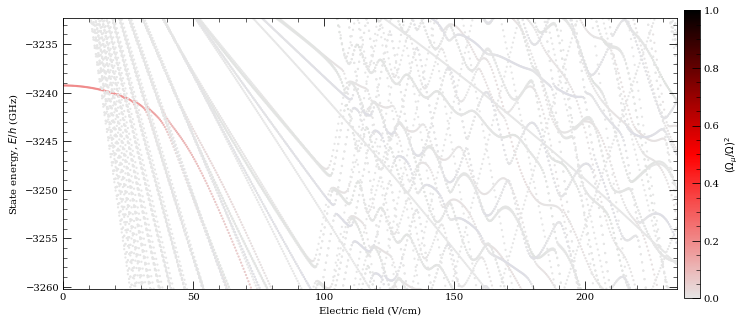

0

In [23]:


calc = StarkMap(Rubidium())

nRange = 13
noOfEigVectors = 500

calc.defineBasis(35, 2, 2.5, 0.5, 35-nRange, 35+nRange, 35,progressOutput=True)
calc.diagonalise(np.linspace(0,235*1.e2,noOfEigVectors),drivingFromState=[5, 1, 1.5, 1.5, -1],\
                 progressOutput=True)
calc.plotLevelDiagram(units=2,highlighState = True,highlightColour="red")

calc.defineBasis(35, 2, 2.5, 1.5, 35-nRange, 35+nRange, 35,progressOutput=True)
calc.diagonalise(np.linspace(0,235*1.e2,noOfEigVectors),drivingFromState=[5, 1, 1.5, 1.5, 0],\
                 progressOutput=True)
calc.plotLevelDiagram(units=2,highlighState = True,highlightColour="green", addToExistingPlot=True)

calc.defineBasis(35, 2, 2.5, 2.5, 35-nRange, 35+nRange, 35,progressOutput=True)

calc.diagonalise(np.linspace(0,235*1.e2,noOfEigVectors),drivingFromState=[5, 1, 1.5, 1.5, +1],\
                 progressOutput=True)
calc.plotLevelDiagram(units=2,highlighState = True,highlightColour="blue", addToExistingPlot=True)

stateEnergy = calc.atom.getEnergy(35,0,0.5)*C_e/(C_h*1.e9)
calc.ax.set_ylim(stateEnergy-21,stateEnergy+7)
calc.showPlot(interactive = False)



# Rydberg atom interactions

As described above, the Rydberg states have extremely large dipole moments making them ideal candidates for controlled long-range interactions in quantum information processing and for studying effects such as resonant energy transfer or superradiance.

For two atoms separated by distance $\textbf{R}$ the dipole-dipole interaction is given by

\begin{equation}
V(\textbf{R}) =  \frac{\textbf{$\mu$}_1\cdot\textbf{$\mu$}_2}{R^3} -\frac{3(\textbf{$\mu$}_1\cdot\textbf{R})(\textbf{$\mu$}_2\cdot\textbf{R})}{R^5},
\end{equation}

where the dipole matrix elements $\mathbf{\mu}_{1,2}$ describe transitions from the initial Rydberg states $\vert r \rangle$ to other dipole-coupled states $\vert r'\rangle,\vert r''\rangle$ respectively. The dipole-coupled pair-states have an energy difference $\Delta$ give by

\begin{equation}
\Delta = E_{r'}+E_{r''}-2E_{r},
\end{equation}

with the dominant contribution to the atom-atom interaction arising from the pair state of with smallest absolute defect $\vert \Delta \vert$. Reducing this to a simple two-pair problem, the Hamiltonian for the states $\vert r r\rangle,\vert r'r''\rangle$ is given by

\begin{equation}
\mathcal{H} = \begin{pmatrix}
0 &V(R) \\
V(R)&\Delta
\end{pmatrix},
\end{equation}

which has the eigenvalues

\begin{equation}
\lambda_\pm = \frac{\Delta\pm\sqrt{\Delta^2+4V(R)^2}}{2}.
\end{equation}

This results in two asympotitic limits for the atom-atom interactions:

   **i) Long-range ($V(R)\ll\Delta$)**
    
   In this limit, also known as the Van der Waals regime, pair-state energy is shifted by $-V(R)^2/\Delta\equiv - C_6/R^6$. The sign of the interaction (attractive/repulsive) is determined by $\Delta$, and the interaction scales as $C_6\propto n^{11}$.
    
   **ii) Short-range ($V(R)\gg\Delta$)**
    
   This is known as the resonant dipole-dipole regime with $\lambda=\pm C_3/R^3$ where $C_3\propto n^4$, resulting in significant state mixing.
    
    
The transition between these two regimes is known as the Van der Waals radius occuring at $V(R_\mathrm{vdW})=\Delta$, with $R_\mathrm{vdW}=\sqrt[6]{C_6/\vert\Delta\vert}$.
    
Typically $\Delta\neq0$ for the Rydberg states, however for small $\Delta$ an external electric field can be used to Stark-shift the pair states into resonance known as a Förster resonance, resulting in resonant $C_3/R^3$ behaviour at all radii.



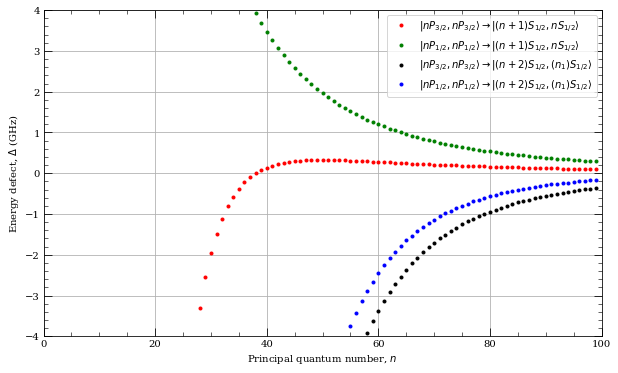

In [24]:
# calcualtion of energy defects and c3 terms for atom-pairs
atom = Rubidium()


nlist=np.arange(25,100,1)
    

fig, axes = plt.subplots(1, 1, figsize=(10,6))

l1 = 1 ; j1 = 1.5 #  P_{3/2}
l2 = 0 ; j2 = 0.5 # S_{1/2}
energyDefect = []
for n in nlist:
    energyDefect.append(atom.getEnergyDefect2(n,l1,j1,n,l1,j1,n+1,l2,j2,n,l2,j2)/(C_h)*1e-9)    
axes.plot(nlist,energyDefect,'r.',\
          label=r"$|n%s_{%d/2},n%s_{%d/2}\rangle\rightarrow\
              |(n+1) %s_{%d/2},n %s_{%d/2}\rangle$"%\
              (printStateLetter(l1),int(2*j1),printStateLetter(l1),int(2*j1),\
              printStateLetter(l2),int(2*j2),printStateLetter(l2),int(2*j2)))

l1 = 1 ; j1 = 0.5 #  P_{3/2}
l2 = 0 ; j2 = 0.5 # S_{1/2}
energyDefect = []
for n in nlist:
    energyDefect.append(atom.getEnergyDefect2(n,l1,j1,n,l1,j1,n+1,l2,j2,n,l2,j2)/(C_h)*1e-9)
axes.plot(nlist,energyDefect,'g.',\
          label=r"$|n%s_{%d/2},n%s_{%d/2}\rangle\rightarrow\
              |(n+1) %s_{%d/2},n %s_{%d/2}\rangle$"%\
              (printStateLetter(l1),int(2*j1),printStateLetter(l1),int(2*j1),\
              printStateLetter(l2),int(2*j2),printStateLetter(l2),int(2*j2)))

l1 = 1 ; j1 = 1.5 #  P_{3/2}
l2 = 0 ; j2 = 0.5 # S_{1/2}
energyDefect = []
for n in nlist:
    energyDefect.append(atom.getEnergyDefect2(n,l1,j1,n,l1,j1,n+2,l2,j2,n-1,l2,j2)/(C_h)*1e-9)
axes.plot(nlist,energyDefect,'k.',\
          label=r"$|n%s_{%d/2},n%s_{%d/2}\rangle\rightarrow\
              |(n+2) %s_{%d/2},(n_1) %s_{%d/2}\rangle$"%\
              (printStateLetter(l1),int(2*j1),printStateLetter(l1),int(2*j1),\
              printStateLetter(l2),int(2*j2),printStateLetter(l2),int(2*j2)))

l1 = 1 ; j1 = 0.5 #  P_{3/2}
l2 = 0 ; j2 = 0.5 # S_{1/2}
energyDefect = []
for n in nlist:
    energyDefect.append(atom.getEnergyDefect2(n,l1,j1,n,l1,j1,n+2,l2,j2,n-1,l2,j2)/(C_h)*1e-9)
axes.plot(nlist,energyDefect,'b.',\
          label=r"$|n%s_{%d/2},n%s_{%d/2}\rangle\rightarrow\
              |(n+2) %s_{%d/2},(n_1) %s_{%d/2}\rangle$"%\
              (printStateLetter(l1),int(2*j1),printStateLetter(l1),int(2*j1),\
              printStateLetter(l2),int(2*j2),printStateLetter(l2),int(2*j2)))


axes.set_ylim(-4,4)
axes.set_xlim(0,100)
axes.legend(loc=0,fontsize=10)
axes.set_ylabel("Energy defect, $\Delta$ (GHz)")
axes.set_xlabel("Principal quantum number, $n$")
axes.grid()
plt.legend
plt.show()

The obtained plot can be compared with Fig. 8 (for Rb) in Ref. [Thad G. Walker and M. Saffman, PRA **77**, 032723 (2008)](https://doi.org/10.1103/PhysRevA.77.032723). Similar paper provides $C_6$ calculations for individual coulping channels. We can reproduce examples corresponding to Eq. (50a-c) in the same reference simply by calling:

In [25]:
channels = [[70,0,0.5, 70, 1,1.5, 69,1, 1.5],\
            [70,0,0.5, 70, 1,1.5, 69,1, 0.5],\
            [70,0,0.5, 69, 1,1.5, 70,1, 0.5],\
            [70,0,0.5, 70, 1,0.5, 69,1, 0.5]]
    
print(" = = = Caesium = = = ")
atom = Caesium()
for channel in channels:
    print("%.0f  GHz (mu m)^6" % ( atom.getC6term(*channel)/C_h*1.e27 ))
    
print("\n = = = Rubidium  = = =")
    
atom = Rubidium()
for channel in channels:
    print("%.0f  GHz (mu m)^6" % ( atom.getC6term(*channel)/C_h*1.e27 ))

 = = = Caesium = = = 
722  GHz (mu m)^6
316  GHz (mu m)^6
382  GHz (mu m)^6
227  GHz (mu m)^6

 = = = Rubidium  = = =
799  GHz (mu m)^6
543  GHz (mu m)^6
589  GHz (mu m)^6
437  GHz (mu m)^6


## Dispersion Coefficients

For the long-range limit, the $C_6$ dispersion coefficient can be calculated using second-order petubation theory valid for $R>R_\mathrm{vdW}$ and taking a sum over all dipole-coupled pair-states using the equation

\begin{equation}
C_6 = \displaystyle\sum_{r'r''} \frac{\left| \langle r'r''\vert V(R) \vert rr\rangle\right|^2}{\Delta_{r',r''}}.
\end{equation}

As well as the dependence upon the sign of $\Delta$ for attractive/repulsive interactions, the form of the dipole interaction above is anisotropic leading to a strong angular sensitivity. Defining an angle $(\theta,\phi)$ in spherical basis between the quantization axis and the interatomic separation vector $\textbf{R}$, the plots below highlight the difference in interaction strength of the different $\ell$ states. As a general rule, for the alkali atoms $ns$ states are repulsive ($C_6<0$) and relatively isotropic, whilst $nd$ states are attractive ($C_6>0$) and highly anisotropic.

Note: Typically, this sum is constrained to include only pair states up to a maximum value of $\Delta$ to minimise computational overhead, and this can be set to achieve convergence.

C6 [60 S 1/2] = -138.88 GHz (mum)^6
Note: No saved angular matrix files to be loaded.
(<type 'exceptions.KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x10434f9e0>)


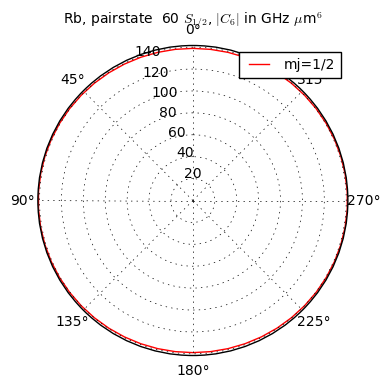

In [2]:
#Dipole-Interaction Dispersion Coefficient:60S1/2
#================================================
#Evaluation of the Cs 60S_1/2 C6 coefficient using perturbation theory (Theta=0,phi=0)
n0=60;l0=0;j0=0.5;mj0=0.5; #Target State
theta=0; #Polar Angle [0-pi]
phi=0; #Azimuthal Angle [0-2pi]
dn = 5; #Range of n to consider (n0-dn:n0+dn)
deltaMax = 25e9 #Max pair-state energy difference [Hz]

#Set target-state and extract value
calculation = PairStateInteractions(Rubidium(), n0,l0,j0,n0,l0,j0, mj0,mj0)
C6 = calculation.getC6perturbatively(theta,phi, dn, deltaMax)
print("C6 [%s] = %.2f GHz (mum)^6" % (printStateString(n0,l0,j0),C6))


#Angular Coupling
#================
#Evaluate C6 as a function of angle
thetaList = np.linspace(0,2*pi,55)
ax = plt.subplot(111, projection='polar')
ax.set_theta_zero_location("N")
line = []

c6 = []
for t in thetaList:
    C6 = calculation.getC6perturbatively(t,phi, dn, deltaMax)
    c6.append(abs(C6))    
    
# plot results
lineLegend, = plt.plot(thetaList,c6,"-",color="r",label=("mj=%d/2"%int(2*mj0)) )
line.append(lineLegend)
        
plt.legend(handles=line,fontsize=10)
plt.title("Rb, pairstate  60 $S_{1/2}$, $|C_6|$ in GHz $\mu$m$^{6}$",fontsize=10)
plt.show()

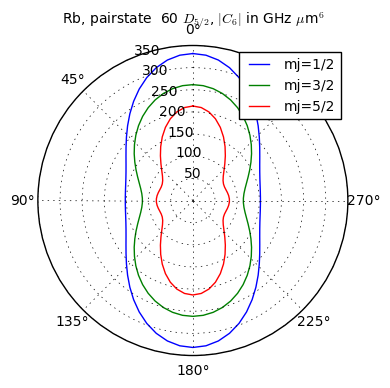

In [25]:
#Dipole-Interaction Dispersion Coefficient:60SD5/2
#=================================================
n0=60;l0=2;j0=2.5;#Target State
phi=0; #Azimuthal Angle [0-2pi]
dn = 5; #Range of n to consider (n0-dn:n0+dn)
deltaMax = 25e9 #Max pair-state energy difference [Hz]

thetaList = np.linspace(0,2*pi,71)
mj = [0.5,1.5,2.5]
colourList = ["b","g","r"]

ax = plt.subplot(111, projection='polar')
ax.set_theta_zero_location("N")
line = []
    
for i in [0,1,2]:
    calculation = PairStateInteractions(Rubidium(), n0,l0,j0,n0,l0,j0, mj[i], mj[i])
    c6 = []
    for t in thetaList:
        C6=calculation.getC6perturbatively(t,phi, dn, deltaMax);
        c6.append(abs(C6))
    
    # plot results
    lineLegend, = plt.plot(thetaList,c6,"-",color=colourList[i],label=("mj=%d/2"%int(2*mj[i])))
    line.append(lineLegend)
        
plt.legend(handles=line,fontsize=10)
plt.title("Rb, pairstate  60 $D_{5/2}$, $|C_6|$ in GHz $\mu$m$^{6}$",fontsize=10)
plt.show()

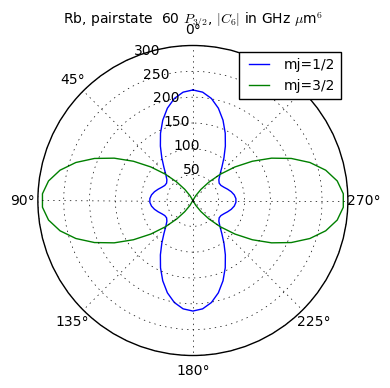

In [26]:
thetaList = np.linspace(0,2*pi,71)
mj = [0.5,1.5]
colourList = ["b","g","r"]

ax = plt.subplot(111, projection='polar')
ax.set_theta_zero_location("N")
line = []
    
for i in [0,1]:
    calculation1 = PairStateInteractions(Rubidium(), 60, 1, 1.5, 60, 1, 1.5, mj[i], mj[i])
    c6 = []
    for t in thetaList:
        c6.append(calculation1.getC6perturbatively(t,0, 5, 25e9))
    
    # plot results
    lineLegend, = plt.plot(thetaList,c6,"-",color=colourList[i],label=("mj=%d/2"%int(2*mj[i])) )
    line.append(lineLegend)
        
plt.legend(handles=line,fontsize=10)
plt.title("Rb, pairstate  60 $P_{3/2}$, $|C_6|$ in GHz $\mu$m$^{6}$",fontsize=10)
plt.show()

For example, we can obtain get results for $C_6$ for Rubidium D states, for which calculations and measurements are presented in Ref. [L.Béguin et.al, PRL **110**, 263201 (2013)](https://doi.org/10.1103/PhysRevLett.110.263201) (see Table I there) simply by calling:

In [2]:
for n in [53,62,82]:
    calculation1 = PairStateInteractions(Rubidium(), n, 2, 1.5, n, 2, 1.5, 1.5, 1.5)
    state = printStateString(n,2,1.5)+" m_j= 3/2"
    c6 = calculation1.getC6perturbatively(0,0, 5, 25e9)
    print("C_6 [%s] = %.0f GHz (mu m)^6" % (state,c6))

C_6 [53 D 3/2 m_j= 3/2] = 16 GHz (mu m)^6
C_6 [62 D 3/2 m_j= 3/2] = 767 GHz (mu m)^6
C_6 [82 D 3/2 m_j= 3/2] = 8866 GHz (mu m)^6


And we can compare calculation results for anisotropic interactions between the two $82 D_{3/2}$ atoms at 12 $\mu$m distance, with measurements reported in [D. Barredo et.al, PRL **112**, 183002 (2014)](https://doi.org/10.1103/PhysRevLett.112.183002) (see Fig. 3 there)

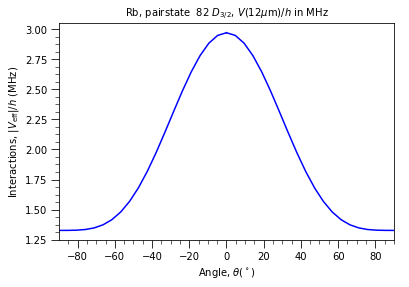

In [10]:
# specification of question

calculation = PairStateInteractions(Rubidium(), 82,2,1.5,82,2,1.5, 1.5, 1.5)
thetaList = np.linspace(0,pi/2.,20)  # orientations of the two atoms
atomDistance = 12. # mu m

# do calculation
interactionVeff = []
for t in thetaList:
    c6 = calculation.getC6perturbatively(t,0.,5,25e9)
    interactionVeff.append((c6/atomDistance**6)*1.e3)
    
# now plotting
ax = plt.subplot(111)
ax.plot(thetaList/pi*180,interactionVeff,"b-")
# symetric plot for 0- >-90
ax.plot(-thetaList/pi*180,interactionVeff,"b-")
ax.set_xlabel(r"Angle, $\theta (^\circ)$")
ax.set_ylabel(r"Interactions, $|V_{\rm eff}|/h$ (MHz)")
ax.set_xlim(-90,90)
plt.title("Rb, pairstate  82 $D_{3/2}$, $V(12 \mu$m$)/h$ in MHz",fontsize=10)
plt.show()

Similarly one can get interactions in Potassium (or Lithium6, Lithium7, Sodium...), simply by changing atom in the calculation initialization. For example for $66 S_{1/2}$ states used in Ref. [S. Helmrich, A. Arias, S. Whitlock, arXiv:1605.08609](https://arxiv.org/abs/1605.08609) by calling

In [3]:
calculation1 = PairStateInteractions(Potassium(),66, 0, 0.5, 66, 0, 0.5, 0.5, 0.5)
c6 = calculation1.getC6perturbatively(0,0, 5, 30e9)
state = printStateString(66,0,0.5)+" m_j= 1/2"
print("C_6 [%s] = %.0f GHz (mu m)^6" % (state,c6))

C_6 [66 S 1/2 m_j= 1/2] = -265 GHz (mu m)^6


## Short-range interactions

For $R<R_\mathrm{vdW}$ it is no longer possible to calculate the interactions using perturbation theory, and instead (as with Stark-shift) it is necessary to diagonalize the pair-state interaction Hamiltionian, taking into account all pair states in the vicinity of the target pair state.


LeRoy radius = 1.1 mum

Calculating Hamiltonian matrix...


	matrix (dimension  2363 )

Matrix R3 100.0 % (state 627 of 627)



Diagonalizing interaction matrix...

99% Now we are plotting...


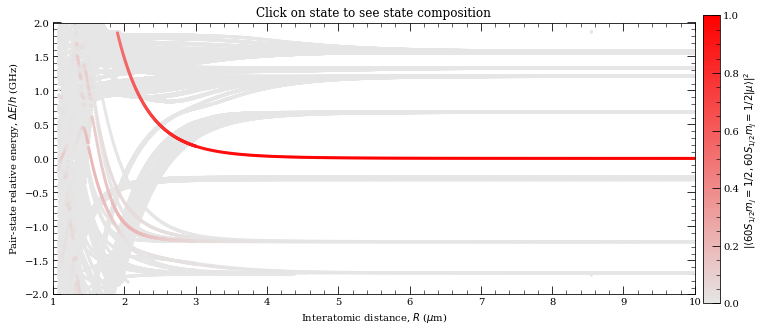

0

In [6]:
#Interaction Potential for 60S1/2
#=================================
n0=60;l0=0;j0=0.5;mj0=0.5; #Target State
theta=0; #Polar Angle [0-pi]
phi=0; #Azimuthal Angle [0-2pi]
dn = 5; #Range of n to consider (n0-dn:n0+dn)
dl = 5; #Range of l values
deltaMax = 25e9 #Max pair-state energy difference [Hz]

#Set target-state
calc = PairStateInteractions(Rubidium(), n0,l0,j0,n0,l0,j0, mj0,mj0,interactionsUpTo = 1)

rvdw = calc.getLeRoyRadius()
print("LeRoy radius = %.1f mum" % rvdw)
#R array (um)
r=np.append(np.linspace(rvdw,3,300),np.linspace(3.01,10.0,300))

#Generate pair-state interaction Hamiltonian
calc.defineBasis(theta,phi, dn,dl, deltaMax,progressOutput=True)
#Diagonalise
nEig=250 #Number of eigenstates to extract
calc.diagonalise(r,nEig,progressOutput=True)
#Plot    
calc.plotLevelDiagram()
#Zoom-on on pair state
calc.ax.set_xlim(1.0,10.0)
calc.ax.set_ylim(-2,2)
calc.showPlot()  # by default program will plot interactive plots
# however plots are interactive only if open oin standard window
# and not in the %inline mode of the notebooks


Obtained plot can be compared with Fig.2(a) in Ref. [N. Sibalic et.al, PRA **94**, 011401(R) (2016)](https://doi.org/10.1103/PhysRevA.94.011401). Continuing with the same calculation, we can now use the build-in funcitions to extract van der Waals range, and values of $C_3$ and $C_6$

Data points to fit =  346
Rvdw =   2.38128945499  mu m
offset =  -5.56132535272e-07 
 scale =  -19.0915248896


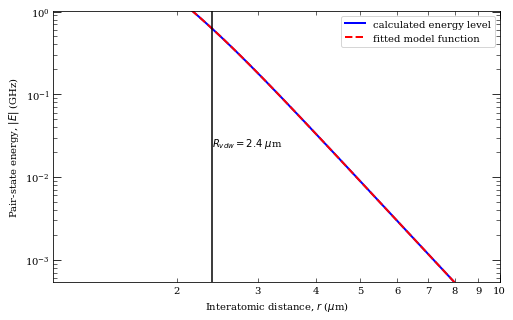

c3 =  15.7544734022  GHz /R^3 (mu m)^3
offset =  -0.541717334602


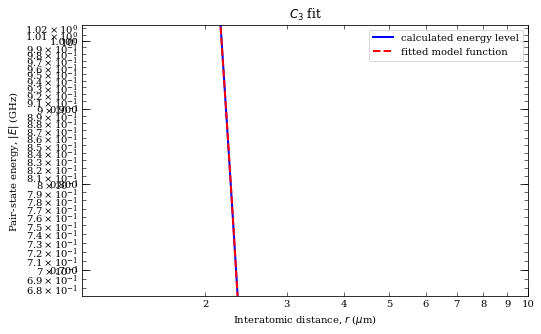

c6 =  134.995416567  GHz /R^6 (mu m)^6
offset =  0.00031664996281


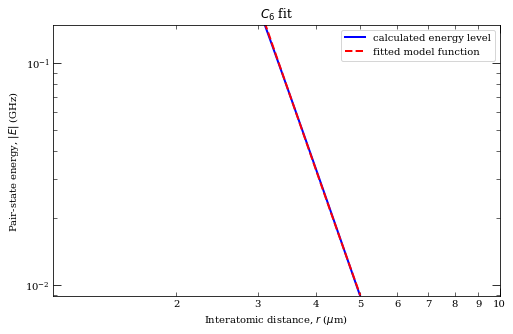

134.99541656743355

In [3]:
rvdw = calc.getVdwFromLevelDiagram(1.000000,8.000000,minStateContribution=0.6,showPlot=True)
calc.getC3fromLevelDiagram(1.8, rvdw*0.99,showPlot=True,minStateContribution=0.5)
calc.getC6fromLevelDiagram(1.3*rvdw, 5.,showPlot=True,minStateContribution=0.5)

Interesting situation with energy levels at short distances are avoided crossings that form potential wells.


Calculating Hamiltonian matrix...


	matrix (dimension  1662 )

Matrix R3 100.0 % (state 340 of 340)



Diagonalizing interaction matrix...

99% Now we are plotting...


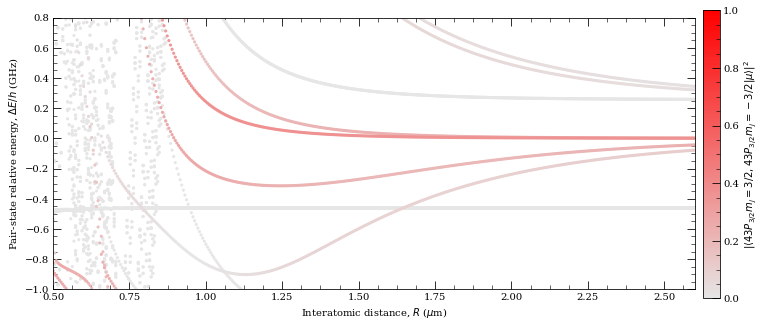

0

In [4]:
calculation1 = PairStateInteractions(Rubidium(), 43, 1, 1.5, 43, 1, 1.5, 1.5, -1.5,interactionsUpTo = 1)
calculation1.defineBasis( 0., 0., 5, 5,30e9,progressOutput=True)
calculation1.diagonalise(np.linspace(0.5,2.6,400),100,progressOutput=True)
    
calculation1.plotLevelDiagram()
calculation1.ax.set_xlim(0.5,2.6)
calculation1.ax.set_ylim(-1.0,0.8)
calculation1.showPlot(interactive=False)

This potential wells can be used for interaction-enhanced dressing discussed in Ref. [R.M.W van Bijnen and T. Pohl, PRL **114**, 243002 (2015)](http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.114.243002). This plot can be compared with $M=0$ states on Fig. 1(c) in the same reference.

At very short range the energy levels are strongly mixed, creating highly complex molecular potentials and requiring a very large basis set to acheive convergence. This effect, also referred to as 'spheghetti', also requires going beyond dipole-dipole interactions and instead include higher-order dipole-quadrupole and quadrupole-quadrupole. This is done using the "interactionsUpTo = 2" command, but is only significant for evaluation of the interaction potential within the dense spheghetti of mode.



Calculating Hamiltonian matrix...


	matrix (dimension  992 )

Matrix R3 100.0 % (state 207 of 207)

Matrix R4 100.0 % (state 207 of 207)

Matrix R5 100.0 % (state 207 of 207)



Diagonalizing interaction matrix...

99% Now we are plotting...


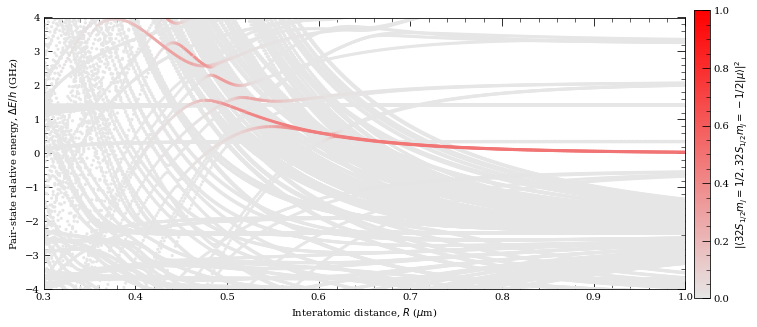

0

In [5]:
calculation1 = PairStateInteractions(Caesium(), 32, 0, 0.5, 32, 0, 0.5, 0.5, -0.5,interactionsUpTo = 2)
calculation1.defineBasis( 0., 0., 5, 5,25e9,progressOutput=True)
calculation1.diagonalise(np.linspace(0.3,1.0,400),300,progressOutput=True)
    
calculation1.plotLevelDiagram()
calculation1.ax.set_xlim(0.3,1.0)
calculation1.ax.set_ylim(-4.0,4.0)
calculation1.showPlot(interactive=False)

## Resonant interactions

When to pair states are resonant, they interact with that scales as $\propto R^{-3}$. This is for example the case for $|dd\rangle \equiv |59~ D_{3/2} ~m_j=3/2, ~59 D_{3/2}~ m_j=3/2 \rangle$ and $|pf\rangle \equiv | 61~ P_{1/2} ~m_j = 1/2, 57~ F_{5/2}~m_j=5/2\rangle$ pair states of Rubidium when the relative pair-staets energies are tuned via the DC Stark effect, applying the external electric field of 32 mV$^{-1}$ cm$^{-1}$. We can obtain theoretical prediction for $C_3$ between these two states, used in [Sylvain R. et. al, Nature Physics **10**, 914 (2014)](dx.doi.org/10.1038/nphys3119), simply by calling

In [10]:
atom = Rubidium()
# coupling od 59 D_{3/2} m_j = 3/2 -> 51 P_{1/2} m_j = 1/2 
dpDME = atom.getDipoleMatrixElement(59, 2, 1.5, 1.5, 61, 1, 0.5, 0.5, -1)
# coupling od 59 D_{3/2} m_j = 3/2 -> 57 F_{5/2} m_j = 5/2 
dfDME = atom.getDipoleMatrixElement(59, 2, 1.5, 1.5, 57, 3, 2.5, 2.5, +1)
c3  = 1/(4.0*pi*epsilon_0)*dpDME*dfDME*C_e**2*\
                (physical_constants["Bohr radius"][0])**2 
print("C_3 = %.3f GHz (mu m)^3 " % (abs(c3)/C_h*1.e9  ))

C_3 = 2.545 GHz (mu m)^3 


Another example where one expects to see resonant transfer of excitations is the case where one of the atoms is excited into the state that has opposite parirty compared to other atoms in it's environment. For example, experiment described in [Daniel Barredo et. al, PRL **114**, 113002 (2015)](https://doi.org/10.1103/PhysRevLett.114.113002) explores chain of Rubidium atoms in $|63~P_{1/2} m_j=1/2\rangle$, and one atom in $|62~D_{3/2}~m_j = 3/2\rangle$ that would be "spin excitation". This excitation will travel along the chain, due to the resonant dipole-dipole interactins, hopping between the atoms with frequency $V(R)/h = \frac{C_3}{h R^3}$. We can obtain prediction for $C_3$ simply by calling

In [11]:
atom = Rubidium()
# coupling of |63 P_{1/2} m_j=1/2, 62 D_{3/2} m_j=3/2> to |62 D_{3/2} m_j=3/2 , 63 P_{1/2} m_j=1/2>
dme = atom.getDipoleMatrixElement(63, 1, 0.5, 0.5, 62, 2, 1.5, 1.5, +1)
c3  = 1/(4.0*pi*epsilon_0)*dme*dme*C_e**2*\
                (physical_constants["Bohr radius"][0])**2 
print("C_3 = %.3f GHz (mu m)^3 " % (abs(c3)/C_h*1.e9  ))

C_3 = 7.971 GHz (mu m)^3 


## Tuning the interaction strength with electric fields

External electric fields can be used to bring some pair-states in resonance with another pair of states. This allows tuning of atom interactions from short range van-der Waals interactions ($\propto R^{-6}$), to stronger, long-range resonant dipole-dipole interactions ($\propto R^{-3}$). ARC provides high-level interface for finding these states through StarkMapResonances calculation class. For example if we want to find states that are resonant with Rubidium $44 D_{5/2} m_j = 5/2$ pair-state, we simply call

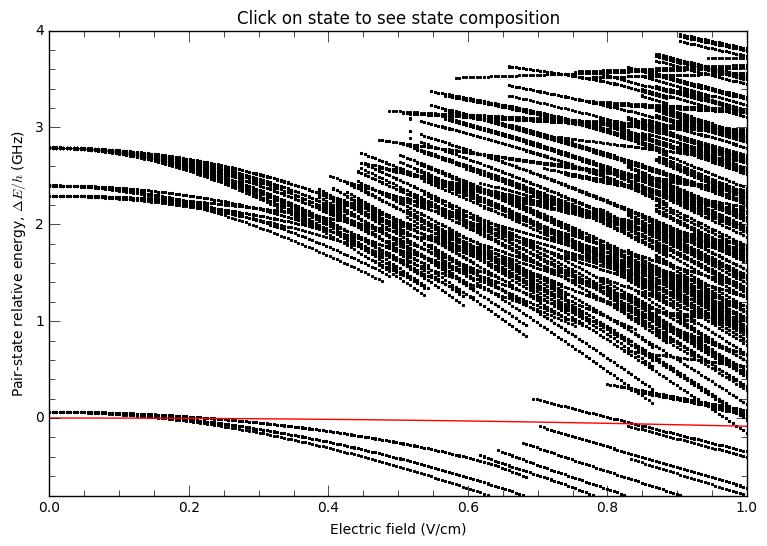

In [12]:
calculation = StarkMapResonances(Rubidium(),[44,2,2.5,2.5],Rubidium(),[44,2,2.5,2.5])
calculation.findResonances(39,49,20,np.linspace(0,100,200),energyRange=[-0.8e9,4.e9])    
calculation.showPlot()    

This generates relevant Stark maps, using:

* states in range n=39-49,
* for electric field range of 0-1 V/cm (0-100 V/m),
* show only energy range [-0.8 GHz, 4 GHz].

Function will automaticaly extract states whose dominant contribution is dipole coulped to  the initial pair-state.

On the plot above, red line corresponds to the original pair-state, and the black points correspond to the states whose dominant contribution (remember that electric field mixes states from initial basis) are dipole coupled to the original pair state. This is useful for interactive use, when one can obtain the contribution of the states resonant with the original pair-state (black dots that are crossing the red line) simply by clicking on them. State composition will then be shown in. Note that this interactive features cannot be used if one calls this from Jupyter (IPython) notebook with $\verb|%matplotlib inline|$ turned on.

### Comparison with experiments

As an example, we can easily find Förster resonances explored in [H. Gorniaczyk et.al, *Nature Comm.* **7**, 12480 (2016)](https://dx.doi.org/10.1038/ncomms12480). Note that plots below don't account for additional 1G magnetic field that was applied in experiment, that caused a small splitting of $m_j$ states ($\sim 5~$MHz) that can be seen on Figure 1b-1c.

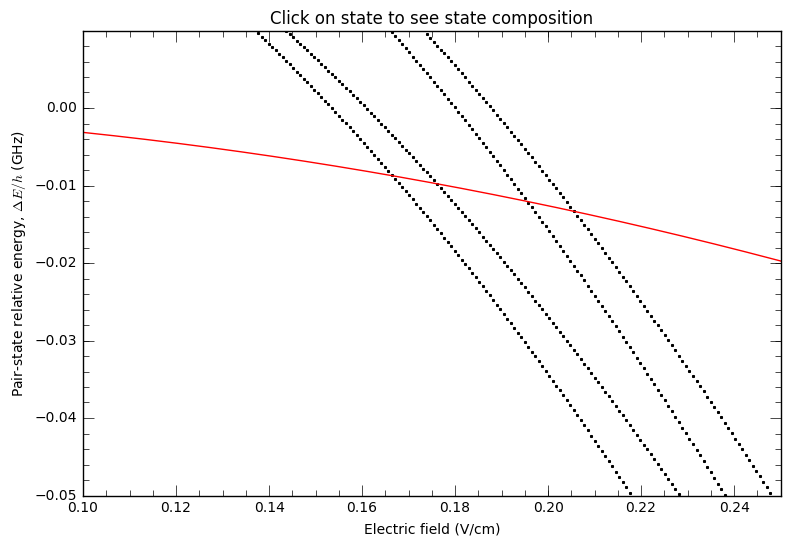

In [13]:
calculation = StarkMapResonances(Rubidium(),[66,0,0.5,0.5],Rubidium(),[64,0,0.5,0.5])
calculation.findResonances(61,71,20,np.linspace(10,25,200),energyRange=[-50.e6,10.e6])    
calculation.showPlot() 

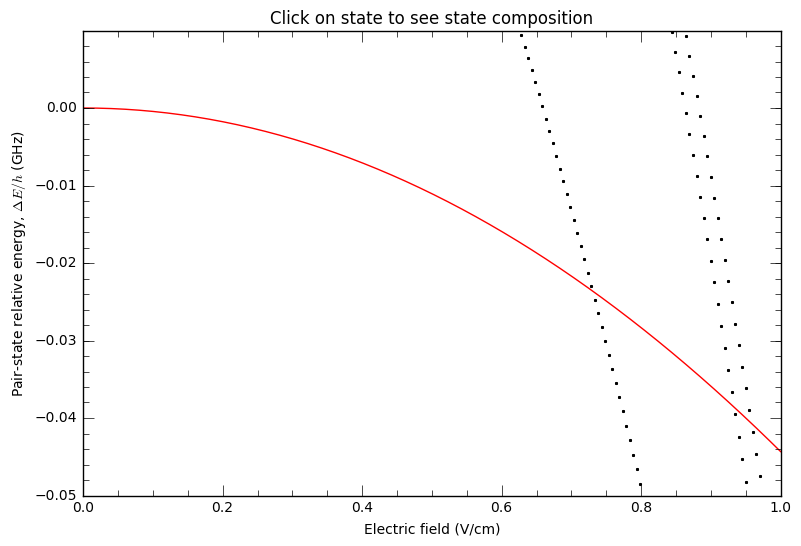

In [14]:
calculation = StarkMapResonances(Rubidium(),[50,0,0.5,0.5],Rubidium(),[48,0,0.5,0.5])
calculation.findResonances(43,55,20,np.linspace(0,100,200),energyRange=[-50.e6,10.e6])    
calculation.showPlot() 

# General atomic properties

For atomic vapours, we can calculate atomic density and average interatomic spacing.

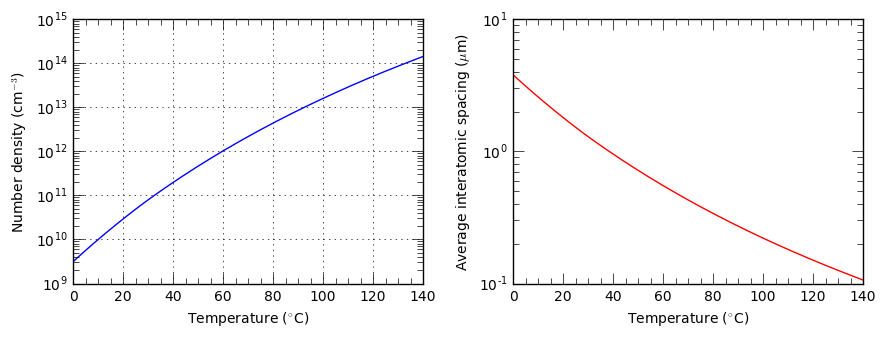

In [15]:
atom = Caesium()
temperature = np.linspace(273.15+0,273.15+140,300)
numberDensity = []
interatomicSpacing = []
for t in temperature:
    numberDensity.append(atom.getNumberDensity(t)*1e-6) # 1e-6 factor converts result to 1/cm^3
    interatomicSpacing.append(atom.getAverageInteratomicSpacing(t)*1e6) #1e6 for um

# plotting results
fig,ax = plt.subplots(1, 2,figsize=(9,3.5))
ax[0].semilogy(temperature-273.15,numberDensity,"b-")
ax[0].set_xlabel("Temperature ($^{\circ}$C)")
ax[0].set_ylabel("Number density (cm$^{-3}$)")
ax[0].grid()

ax[1].semilogy(temperature-273.15,interatomicSpacing,"r-")
ax[1].set_xlabel("Temperature ($^{\circ}$C)")
ax[1].set_ylabel("Average interatomic spacing ($\mu$m)")
ax[1].set_ylim(0.1,10)
plt.tight_layout()
plt.show()


Quick comparison of vapour pressures for different alkali metals:

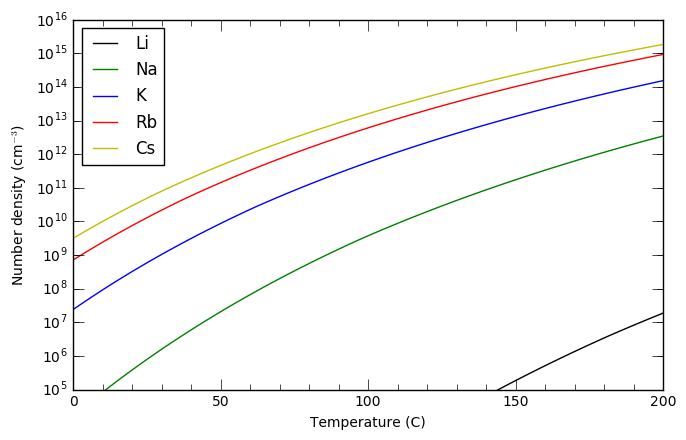

In [5]:
temperature = np.linspace(-5+273.15,210+273.15,100)
atomList = [Lithium6(),Sodium(),Potassium(),Rubidium(),Caesium()]
symbolList = ["k-","g-","b-","r-","y-"]
numberDensity = []


for i in xrange(len(atomList)):
    nd = []
    for t in temperature:
        nd.append(atomList[i].getNumberDensity(t))
    numberDensity.append(np.array(nd))
    
fig = plt.figure(figsize=(7,4.5))
ax = fig.add_subplot(1,1,1)

for i in xrange(len(atomList)):
    ax.semilogy(temperature-273.15,numberDensity[i]/1.e6,symbolList[i])

ax.legend(("Li","Na","K","Rb","Cs"),loc=2)
ax.set_ylabel(r"Number density (cm$^{-3}$)")
ax.set_xlabel("Temperature (C)")
ax.set_xlim(0,200)
ax.set_ylim(1e5,1e16)
    
plt.tight_layout()
plt.show()

# Advanced Rydberg examples

## Scalling of Rydberg blockade with principal quantum number

In [6]:
laserLinewidth = 0.003 # in GHz
nList = np.arange(60,91)
c6List = []
blockadeRadiusList = []
for n in nList:
    calculation1 = PairStateInteractions(Rubidium(), n, 0, 0.5, n, 0, 0.5, 0.5, 0.5)
    state = printStateString(n,0,0.5)+" m_j= 1/2"
    c6 = calculation1.getC6perturbatively(0,0, 5, 35e9)
    blockade = (abs(c6/laserLinewidth))**(1/6.)
    print("C_6 [%s] = %.0f GHz (mu m)^6\t%.1f mu m" % (state,c6,blockade))
    c6List.append(c6)
    blockadeRadiusList.append(blockade)

C_6 [60 S 1/2 m_j= 1/2] = -135 GHz (mu m)^6	6.0 mu m
C_6 [61 S 1/2 m_j= 1/2] = -165 GHz (mu m)^6	6.2 mu m
C_6 [62 S 1/2 m_j= 1/2] = -204 GHz (mu m)^6	6.4 mu m
C_6 [63 S 1/2 m_j= 1/2] = -247 GHz (mu m)^6	6.6 mu m
C_6 [64 S 1/2 m_j= 1/2] = -298 GHz (mu m)^6	6.8 mu m
C_6 [65 S 1/2 m_j= 1/2] = -358 GHz (mu m)^6	7.0 mu m
C_6 [66 S 1/2 m_j= 1/2] = -429 GHz (mu m)^6	7.2 mu m
C_6 [67 S 1/2 m_j= 1/2] = -513 GHz (mu m)^6	7.5 mu m
C_6 [68 S 1/2 m_j= 1/2] = -612 GHz (mu m)^6	7.7 mu m
C_6 [69 S 1/2 m_j= 1/2] = -728 GHz (mu m)^6	7.9 mu m
C_6 [70 S 1/2 m_j= 1/2] = -863 GHz (mu m)^6	8.1 mu m
C_6 [71 S 1/2 m_j= 1/2] = -1020 GHz (mu m)^6	8.4 mu m
C_6 [72 S 1/2 m_j= 1/2] = -1204 GHz (mu m)^6	8.6 mu m
C_6 [73 S 1/2 m_j= 1/2] = -1417 GHz (mu m)^6	8.8 mu m
C_6 [74 S 1/2 m_j= 1/2] = -1663 GHz (mu m)^6	9.1 mu m
C_6 [75 S 1/2 m_j= 1/2] = -1948 GHz (mu m)^6	9.3 mu m
C_6 [76 S 1/2 m_j= 1/2] = -2276 GHz (mu m)^6	9.6 mu m
C_6 [77 S 1/2 m_j= 1/2] = -2656 GHz (mu m)^6	9.8 mu m
C_6 [78 S 1/2 m_j= 1/2] = -3091 GHz (mu

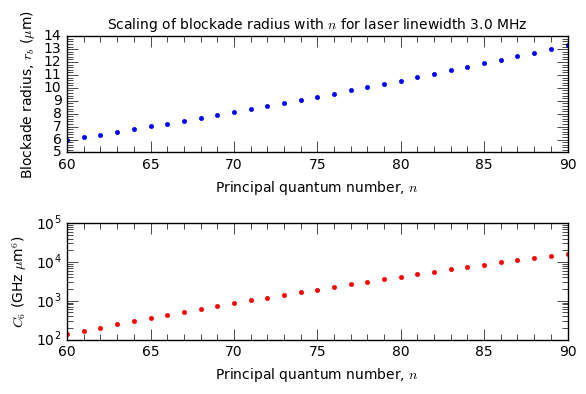

In [7]:
ax = plt.subplot(2,1,1)
ax.plot(nList,blockadeRadiusList,"b.")
ax.set_xlabel(r"Principal quantum number, $n$")
ax.set_ylabel(r"Blockade radius, $r_b$ ($\mu$m)")
ax.set_title(r"Scaling of blockade radius with $n$ for laser linewidth %.1f MHz"% \
             (laserLinewidth*1.e3), fontsize=10)
ax = plt.subplot(2,1,2)
ax.semilogy(nList,abs(np.array(c6List)),"r.")
ax.set_xlabel(r"Principal quantum number, $n$")
ax.set_ylabel(r"$C_6$ (GHz $\mu$m$^6$)")
plt.tight_layout()
plt.show()

## Calculation of Le Roy radius
Below charateristic distance $R_\mathrm{LR}=2(\langle r^2_1 \rangle^{1/2}+\langle r^2_2 \rangle^{1/2})$ where $r_1$ and $r_2$ are electron coordinatese for the first and the second of the two interacting atoms, there is a significant overlap between the two electron wavefunctions, and calculations based on diagonalization of the pair-states become invalid. Below we calculate the Le Roy radius for pairs of Caesium $n$ $S_{1/2}$ atoms, indicating lower interatomic distance for which PairStateInteractions calculations are correct.

In [8]:
nrange = [7,17,27,37,47,57,67,77,87,97,107]
leRoyRadius = []
for n in nrange:
    calc = PairStateInteractions(Caesium(), n, 0, 0.5, n, 0, 0.5, 0.5, -0.5)
    leRoyRadius.append( calc.getLeRoyRadius() ) 


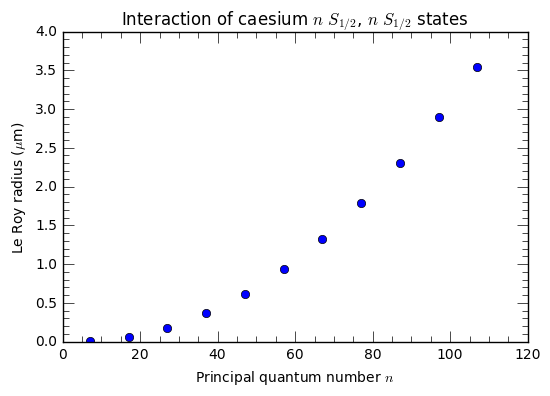

In [9]:
f = plt.figure()
ax = f.add_subplot(1,1,1)
ax.plot(nrange,leRoyRadius,"bo")
ax.set_xlabel(r"Principal quantum number $n$")
ax.set_ylabel(r"Le Roy radius ($\mu$m)")
ax.set_title(r"Interaction of caesium $n$ $S_{1/2}$, $n$ $S_{1/2}$ states")

## Off-resonant excitation

If we are interested in pair-state energy levels at some fixed detuning for the non-interacting pair-state energy, we can look at plots like the ones shown in [Short range interactions](#Short-range-interactions). However, we can also directly look at, for example, 25 eigenstates that are closest to 1 GHz detuning from the non-interacting pair-state energy. For this we will set number of requested eigenvectors *nEig* to 25, and use optional parameter *eigenstateDetuning* = 1.e9 (detuning in GHz). We see below that we directly, and more faster, obtain levels at particular detuning (compare plot below with plot in [Short range interactions](#Short-range-interactions) ).

LeRoy radius = 1.1 mum

Calculating Hamiltonian matrix...


	matrix (dimension  2363 )

Matrix R3 100.0 % (state 627 of 627)



Diagonalizing interaction matrix...

99% Now we are plotting...


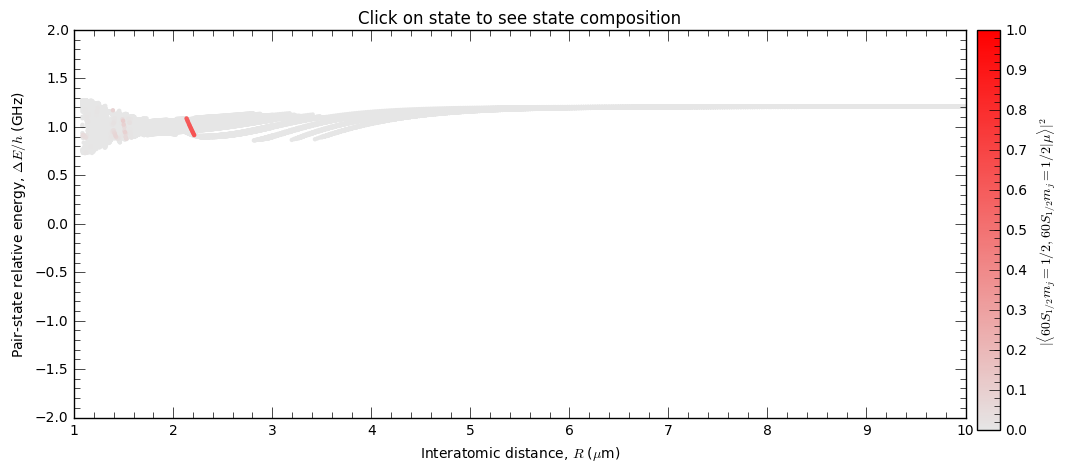

0

In [10]:
#Interaction Potential for 60S1/2
#=================================
n0=60;l0=0;j0=0.5;mj0=0.5; #Target State
theta=0; #Polar Angle [0-pi]
phi=0; #Azimuthal Angle [0-2pi]
dn = 5; #Range of n to consider (n0-dn:n0+dn)
dl = 5; #Range of l values
deltaMax = 25e9 #Max pair-state energy difference [Hz]


#Set target-state
calc = PairStateInteractions(Rubidium(), n0,l0,j0,n0,l0,j0, mj0,mj0,interactionsUpTo = 1)
rvdw = calc.getLeRoyRadius()
print("LeRoy radius = %.1f mum" % rvdw)
#R array (um)
r=np.append(np.linspace(rvdw,3,300),np.linspace(3.01,10.0,300))
#Generate pair-state interaction Hamiltonian
calc.defineBasis(theta,phi, dn,dl, deltaMax,progressOutput=True)
#Diagonalise
nEig=25 #Number of eigenstates to extract
calc.diagonalise(r,nEig,progressOutput=True, eigenstateDetuning = 1.e9)
#Plot    
calc.plotLevelDiagram()
#Zoom-on on pair state
calc.ax.set_xlim(1.0,10.0)
calc.ax.set_ylim(-2,2)
calc.showPlot()  # by default program will plot interactive plots
# however plots are interactive only if open oin standard window
# and not in the %inline mode of the notebooks


We see that for $1~$GHz blue-detuned laser, there is facilitation sphere in excitation dynamics at inter-atomic distance of about 2.1-2.2$~\mu$m.

## Calculation of dipole matrix elements between states in static electric field

As we have seen in [Stark map calculation section](#Rydberg-Atom-Stark-Shifts), eigen-states in the electric field are strongly admixed bare states. Here we provide a way of calculating dipole matrix elements between two states in electric field. Firstly, we will write calculation class, demonstrating how one can access and reconstruct directly Stark Hamiltonian from provided class variables. Then we will present an example of calculation of d.m.e. in electric field.

In [14]:
from scipy.sparse import csr_matrix

class MatrixElementsEfield:
    
    def __init__(self,StarkMap1,StarkMap2, progressOutput = False):
        """
            calculates dipolar coupling between the two original target states
            of the two Stark Maps
        
            Note:
                StarkMaps have to have **defined basis** 
                AND
                StarkMaps have to be calculated **for the same atom**
        """
        # save pointers to Stark maps for later
        self.StarkMap1 = StarkMap1
        self.StarkMap2 = StarkMap2
        
        # construct and save CSV sparce matrix of couplings
        matrixDMEcoupling = [[],[],[]]
        
        for i in range(len(StarkMap1.basisStates)):
            if progressOutput:
                sys.stdout.write("\r%d%%" % (float(i)/float(len(StarkMap1.basisStates)-1)*100))
                sys.stdout.flush()
            for j in range(len(StarkMap2.basisStates)):
                # if dipole coupled, add to coupling
                dl = abs(StarkMap1.basisStates[i][1]-StarkMap2.basisStates[j][1])
                dj = abs(StarkMap1.basisStates[i][2]-StarkMap2.basisStates[j][2])
                if dl==1 and (dj<1.1):
                    dme = StarkMap1.atom.getDipoleMatrixElement(\
                                          StarkMap1.basisStates[i][0],StarkMap1.basisStates[i][1],\
                                          StarkMap1.basisStates[i][2], StarkMap1.basisStates[i][3],\
                                          StarkMap2.basisStates[j][0], StarkMap2.basisStates[j][1],\
                                          StarkMap2.basisStates[j][2], StarkMap2.basisStates[j][3],\
                                          q)
                    matrixDMEcoupling[0].append(dme)
                    matrixDMEcoupling[1].append(i)
                    matrixDMEcoupling[2].append(j)
                    
        self.matrixDMEcoupling = csr_matrix((matrixDMEcoupling[0], \
                                 (matrixDMEcoupling[1], matrixDMEcoupling[2])),\
                                shape=(len(StarkMap1.basisStates), len(StarkMap2.basisStates)) )


    def getDipolarCoupling(self,eField):
        """
            find dipolar coupling and transition frequency between target states
            
            Target states are specified during the initialization procedure of the StarkMap1 and StarkMap2
        """

        # find first state in electric field
        m = self.StarkMap1.mat1 + self.StarkMap1.mat2 * eField
        ev,egvector = eigh(m)

        # locate which of the eigenvectors has biggest contribution of the orginal state
        # and save that state composition
        # NOTE: advanced users might want to change this close to avoided crossings
        state1index = np.argmax( np.absolute( egvector[self.StarkMap1.indexOfCoupledState,:] ) )
        state1composition = egvector[:,state1index]
        energy1 = ev[state1index]
    
        # find second state in electric field
        m = self.StarkMap2.mat1 + self.StarkMap2.mat2 * eField
        ev,egvector = eigh(m)

        # locate which of the eigenvectors has biggest contribution of the orginal state, and save that state composition
        state2index = np.argmax( np.absolute( egvector[self.StarkMap2.indexOfCoupledState,:] ) )
        state2composition = egvector[:,state2index]
        energy2 = ev[state2index]
    
        # find coupling between the states

        coupling = self.matrixDMEcoupling.dot(state2composition).dot(state1composition)
               
        return abs(coupling),abs(energy1-energy2)
                                            

Now let's use above defined class to calculate coupling between caesium Rydberg states in electric field

In [15]:
# Stark map for the first state
mj1 = 0.5
mj2 = 0.5
q = 0 # pi transistions

atom = Caesium()

deltaN = 5
maxL = 20

print("1:")
stMap1 = StarkMap(atom)
stMap1.defineBasis(21,1,1.5, mj1,21-deltaN,21+deltaN,maxL,progressOutput = True)
print("2:")
stMap2 = StarkMap(atom)
stMap2.defineBasis(21,0,0.5, mj2,21-deltaN,21+deltaN+1,maxL,progressOutput = True)


calc = MatrixElementsEfield(stMap1,stMap2, progressOutput = True)
c,f = calc.getDipolarCoupling(500.e2)

couplingList = []
frequencyList = []
eFieldList = np.linspace(0,500.e2,51)
for eField in eFieldList:
    c, f = calc.getDipolarCoupling(eField)
    couplingList.append(c )
    frequencyList.append(f)


1:
Found  380  states.
Generating matrix...
100%

2:
Found  421  states.
Generating matrix...
100%

100%

And let's plot obtained couplings and frequencies over the range of electric fields

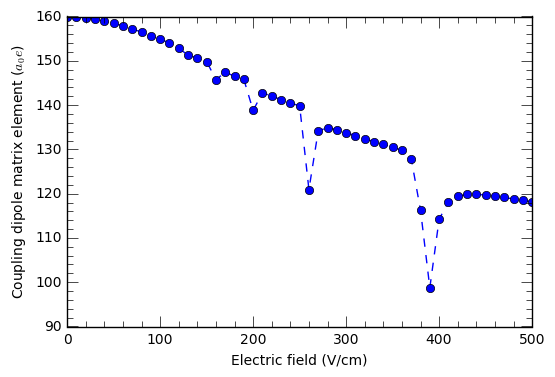

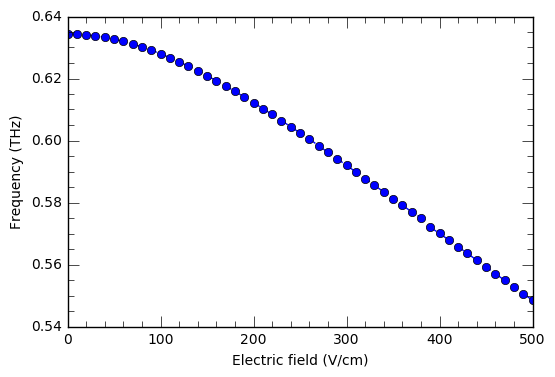

In [16]:
plt.plot(eFieldList/1e2,couplingList,"o--")
plt.xlabel("Electric field (V/cm)")
plt.ylabel(r"Coupling dipole matrix element ($a_0 e$)")
plt.show()

plt.plot(eFieldList/1e2,np.array(frequencyList)/1.e3,"o--")
plt.xlabel("Electric field (V/cm)")
plt.ylabel(r"Frequency (THz)")
plt.show()

# Advanced use of ARC package: interfacing and expansions

Here we describe way to further interface your calculation projects with ARC.

## Saving and retrieving calculations

If you want to save and load and continue calculation on another computer, or at later time, this is the option you are looking for. See documentation (and examples in documentation) about [saving calculations](http://arc-alkali-rydberg-calculator.readthedocs.io/en/latest/alkali_atom_functions.html#arc.alkali_atom_functions.saveCalculation) and [loading saved calculations](http://arc-alkali-rydberg-calculator.readthedocs.io/en/latest/alkali_atom_functions.html#arc.alkali_atom_functions.loadSavedCalculation).

## Export of data in .csv

If you want to export graph data for use in another non-Python program, this is the option you are looking for. See documentation about [exporting Stark map calculation data](http://arc-alkali-rydberg-calculator.readthedocs.io/en/latest/calculations_atoms_single.html#arc.calculations_atom_single.StarkMap.exportData) and about [exporting pair-state interactions data](http://arc-alkali-rydberg-calculator.readthedocs.io/en/latest/calculations_atom_pairstate.html#arc.calculations_atom_pairstate.PairStateInteractions.exportData). If, however, you want more detailed export of data (not just graph data), check the next option.

## Using calculated matrices and basis states in your own projects

If you want to access matrices used in calculation and corresponding basis states, to incorporate them in you Python program, or in order to make custom data outputs, this is the option you are looking for.

For StarkMap calculations check documentation of [defineBasis](http://arc-alkali-rydberg-calculator.readthedocs.io/en/latest/calculations_atoms_single.html#arc.calculations_atom_single.StarkMap.defineBasis) and **Advanced interfacing of Stark map calculations (StarkMap class)** example in [StarkMap class initalization documentation](http://arc-alkali-rydberg-calculator.readthedocs.io/en/latest/calculations_atoms_single.html#arc.calculations_atom_single.StarkMap).

For PairStateInteractions calculations check documentation of [defineBasis](http://arc-alkali-rydberg-calculator.readthedocs.io/en/latest/calculations_atom_pairstate.html#arc.calculations_atom_pairstate.PairStateInteractions.defineBasis) and **Advanced interfacing of pair-state interactions calculations (PairStateInteractions class)** example in [PairStateInteractions class initalization documentation](http://arc-alkali-rydberg-calculator.readthedocs.io/en/latest/calculations_atom_pairstate.html#arc.calculations_atom_pairstate.PairStateInteractions).

Also check documentation about all the accessible variables from both classes and, if that is not enough, feel free do dig into the code! There are additional comments in the code that should help you with navigation there.

An example of building up a calculation by directly accessing the Stark Hamiltonian is provided in [this advanced example](#Calculation-of-dipole-matrix-elements-between-states-in-static-electric-field) of matrix elements calculations for states in electric field.